In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [3]:
from itertools import islice
from eden.util.display import draw_graph_set

def draw_graphs(graphs, vertex_label='label'):
    n_graphs_per_line = 3
    n_lines = 2
    max_n_examples = n_graphs_per_line * n_lines
    graphs =islice(graphs, max_n_examples)
    draw_graph_set(graphs, n_graphs_per_line=n_graphs_per_line, size=14, title_key='id', prog='neato', node_border=1, node_size=200, colormap='Set3',
               edge_color='_label_',edge_alpha=.3, vertex_label=vertex_label, vertex_color='_label_', ignore_for_layout='nesting')

---

# Molecular graphs

In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [10]:
from GArDen.convert.graph import GspanToGraph
from GArDen.interfaces import convert
fname = 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan'
graphs = convert(fname, program=GspanToGraph())

In [6]:
from GArDen.transform.minimal_cycle_annotation import AnnotateMinimalCycles
from GArDen.interfaces import transform
#graphs = transform(graphs, program=AnnotateMinimalCycles())

In [7]:
from GArDen.transform.contraction import Minor, contraction_modifier
#reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
modifier_list = [weight_modifier]
from GArDen.interfaces import transform
priors=dict(nesting=True,  modifiers=[modifier_list], weight_scaling_factor=1)
graphs=transform(graphs, program=Minor(), parameters_priors=priors)

In [8]:
#draw_graphs(graphs, vertex_label='label')

In [11]:
%%time
graphs = list(graphs)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi.gspan HTTP/1.1" 200 1207117
CPU times: user 1.17 s, sys: 78.7 ms, total: 1.25 s
Wall time: 2.49 s


In [12]:
from sklearn.cluster import KMeans
parameters_priors=dict(n_clusters=8, init='k-means++', n_init=10, max_iter=50, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=-1)
clusterer = KMeans()

In [19]:
from sklearn.cluster import DBSCAN
parameters_priors=dict(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, random_state=None)
clusterer = DBSCAN()

In [20]:
from GArDen.partition import ClustererWrapper
wrapped_clusterer = ClustererWrapper(program=clusterer)

In [21]:
%%time
from GArDen.interfaces import partition
parameters_priors.update(dict(vectorizer__r=2,vectorizer__d=2, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
partition_list = partition(graphs, program=wrapped_clusterer, parameters_priors=parameters_priors)

CPU times: user 11.2 s, sys: 2.09 s, total: 13.3 s
Wall time: 18.3 s


In [22]:
min_clust_size = 5
max_clust_size = 30
for cluster_id in partition_list:
    clust_size=len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print 'cluster id: %d size:%d' % (cluster_id, clust_size )

cluster id: 1 size:10
cluster id: 3 size:6
cluster id: 7 size:7
cluster id: 8 size:13
cluster id: 9 size:11
cluster id: 10 size:6
cluster id: 11 size:6
cluster id: 12 size:6
cluster id: 13 size:20
cluster id: 14 size:9
cluster id: 15 size:6
cluster id: 16 size:8
cluster id: 17 size:6
cluster id: 18 size:6
cluster id: 20 size:7
cluster id: 21 size:6
cluster id: 23 size:6
cluster id: 24 size:6
cluster id: 25 size:7
cluster id: 27 size:6
cluster id: 28 size:6
cluster id: 29 size:6


--------------------------------------------------------------------------------
cluster:1 size:10


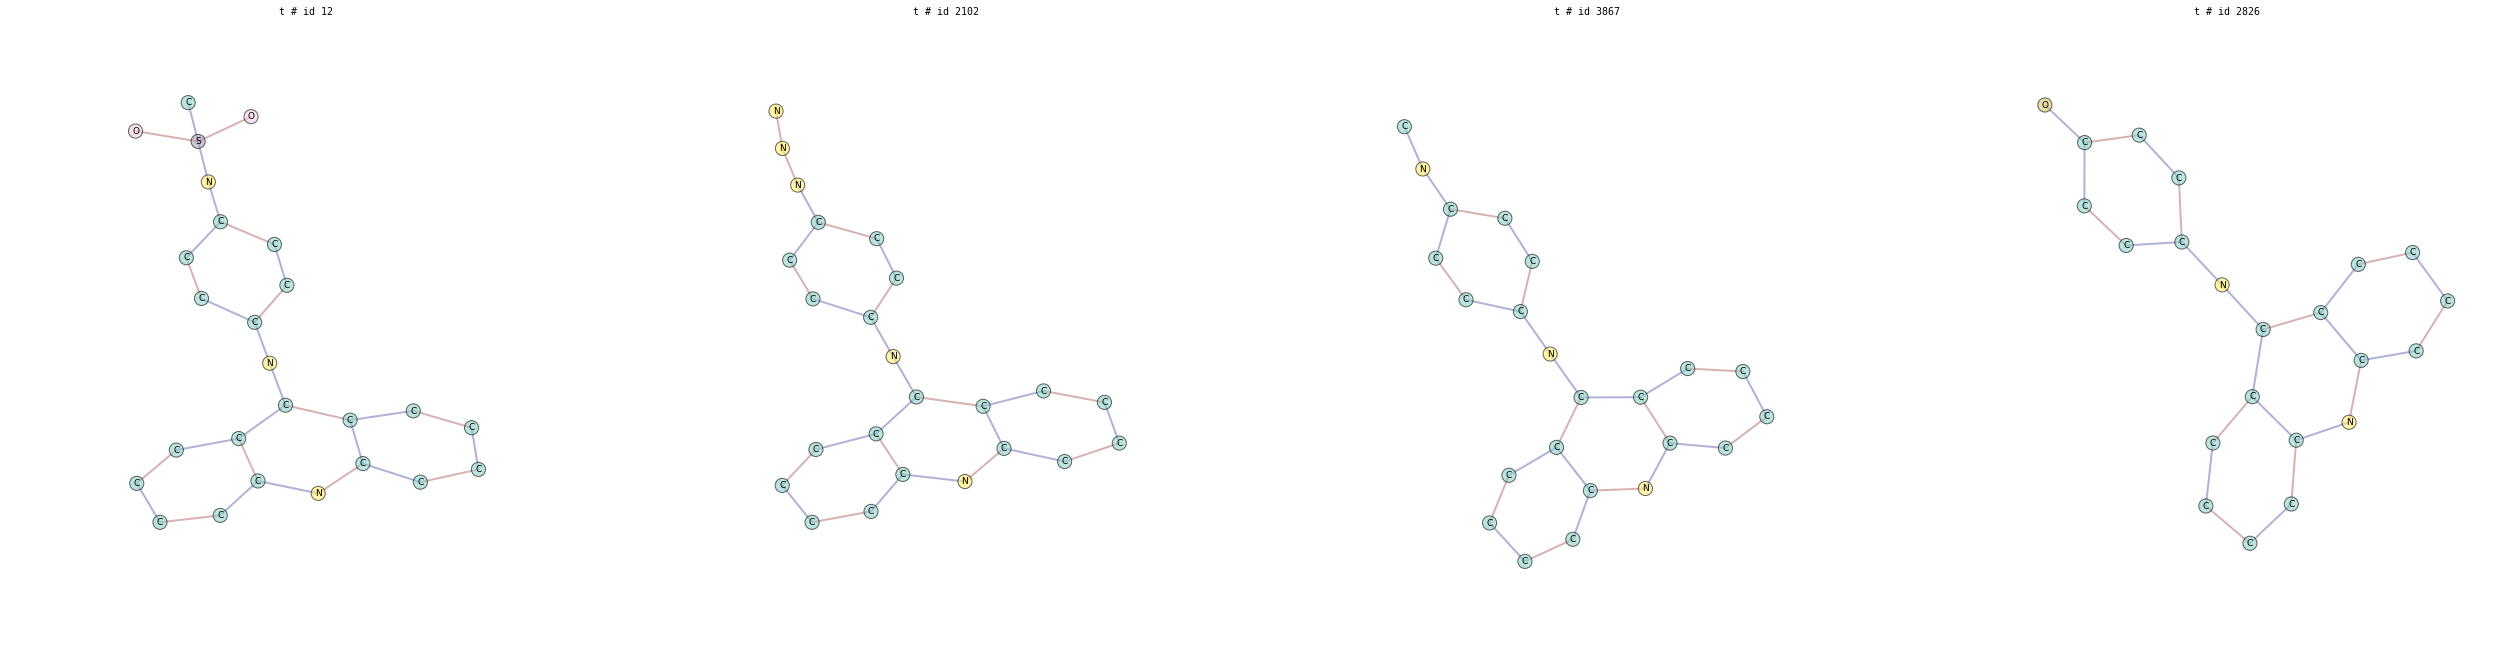

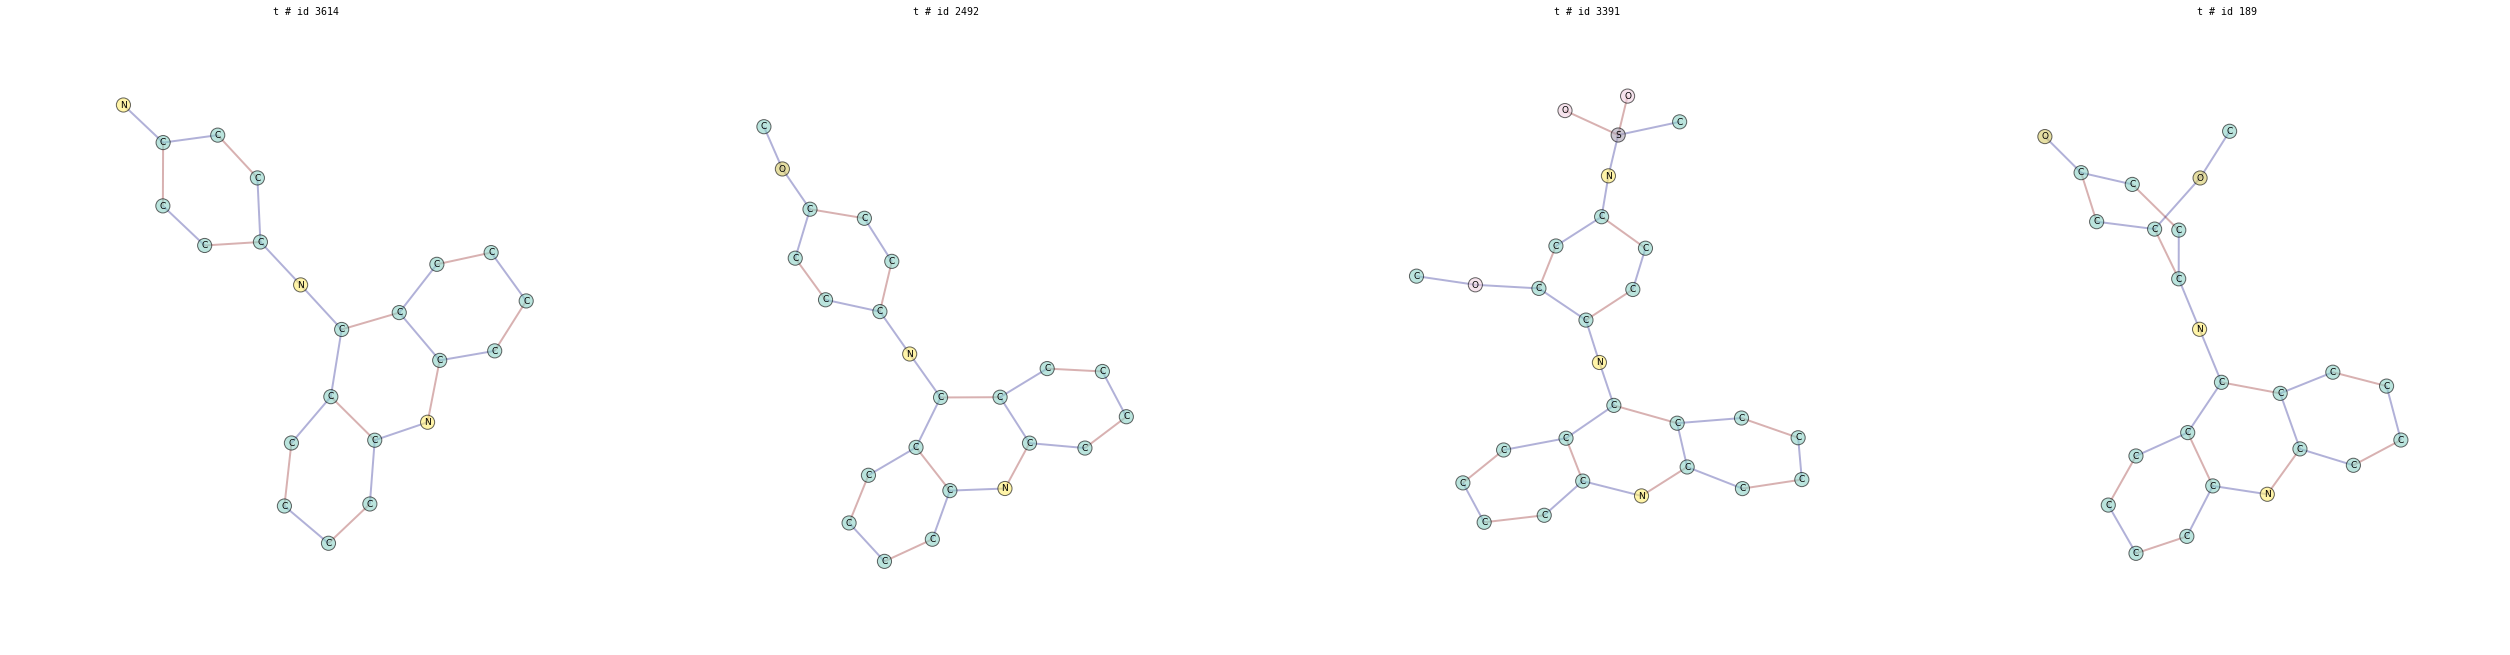

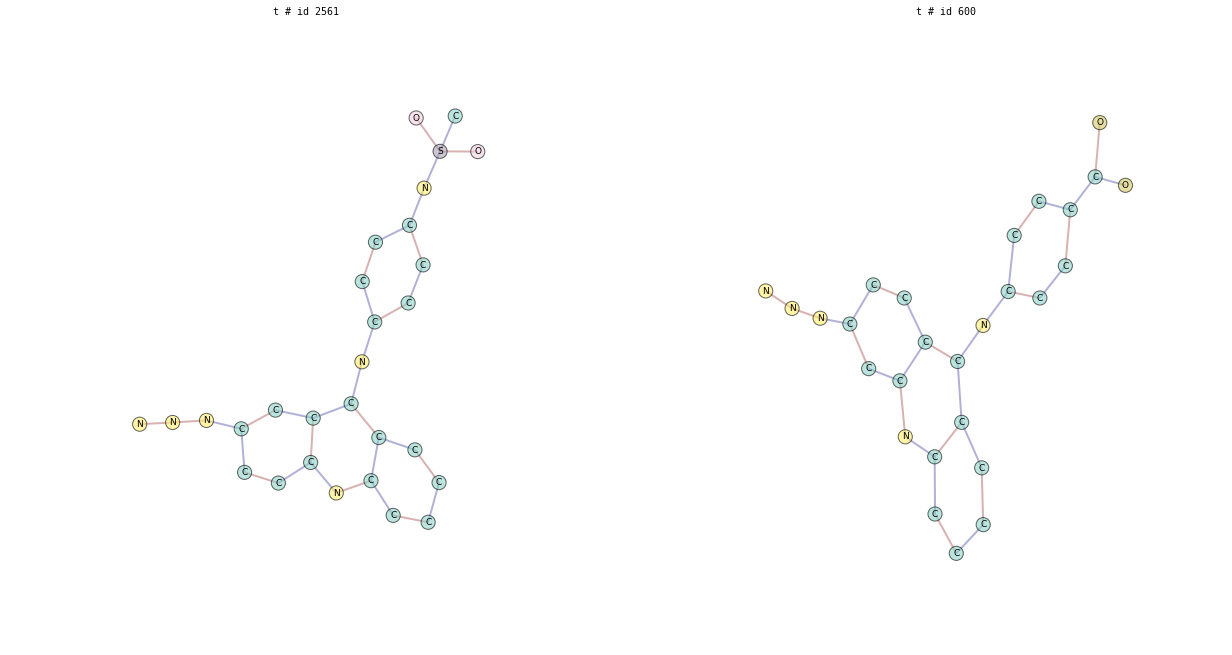

--------------------------------------------------------------------------------
cluster:3 size:6


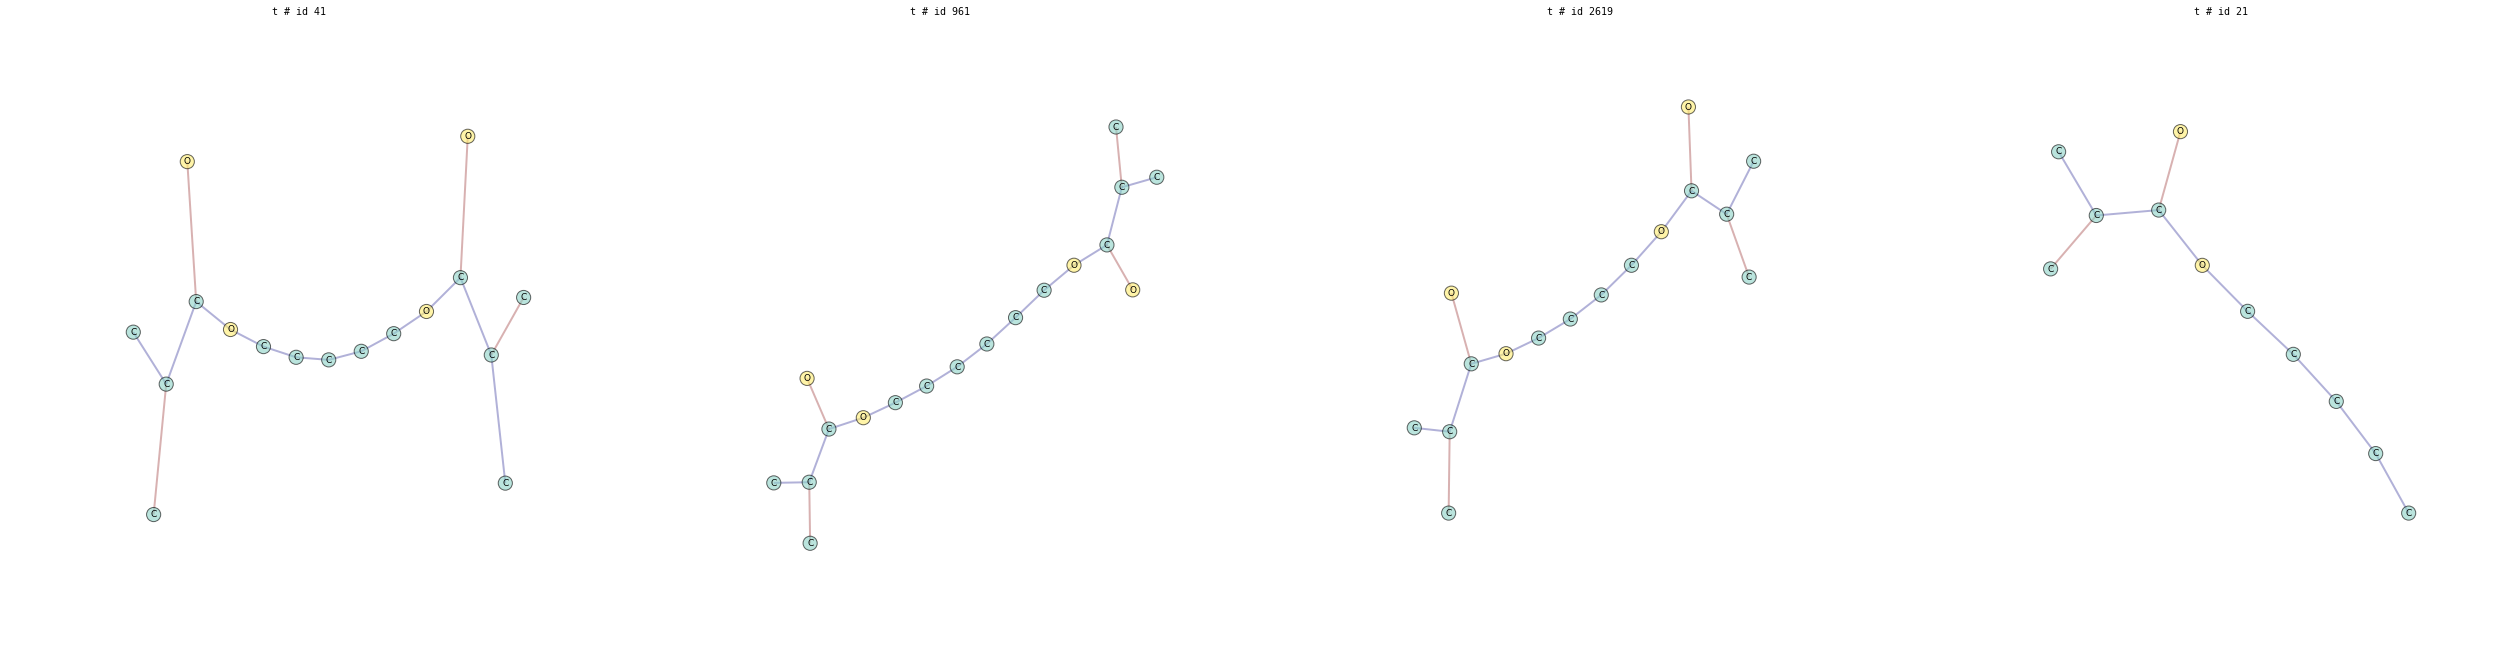

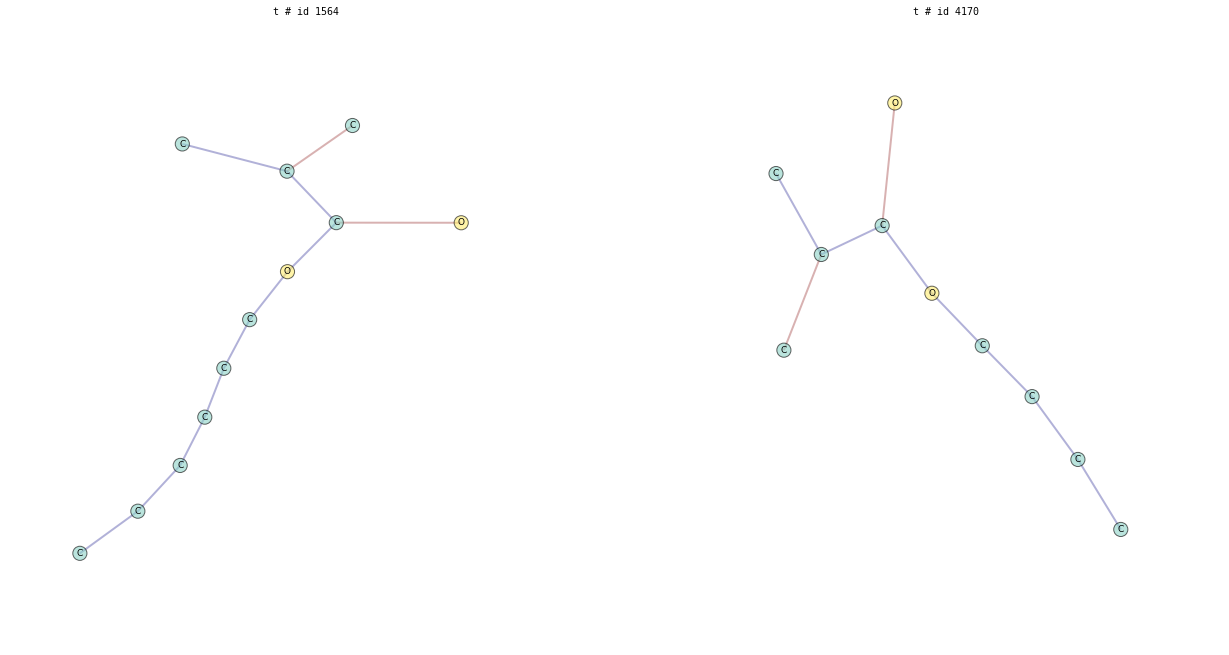

--------------------------------------------------------------------------------
cluster:7 size:7


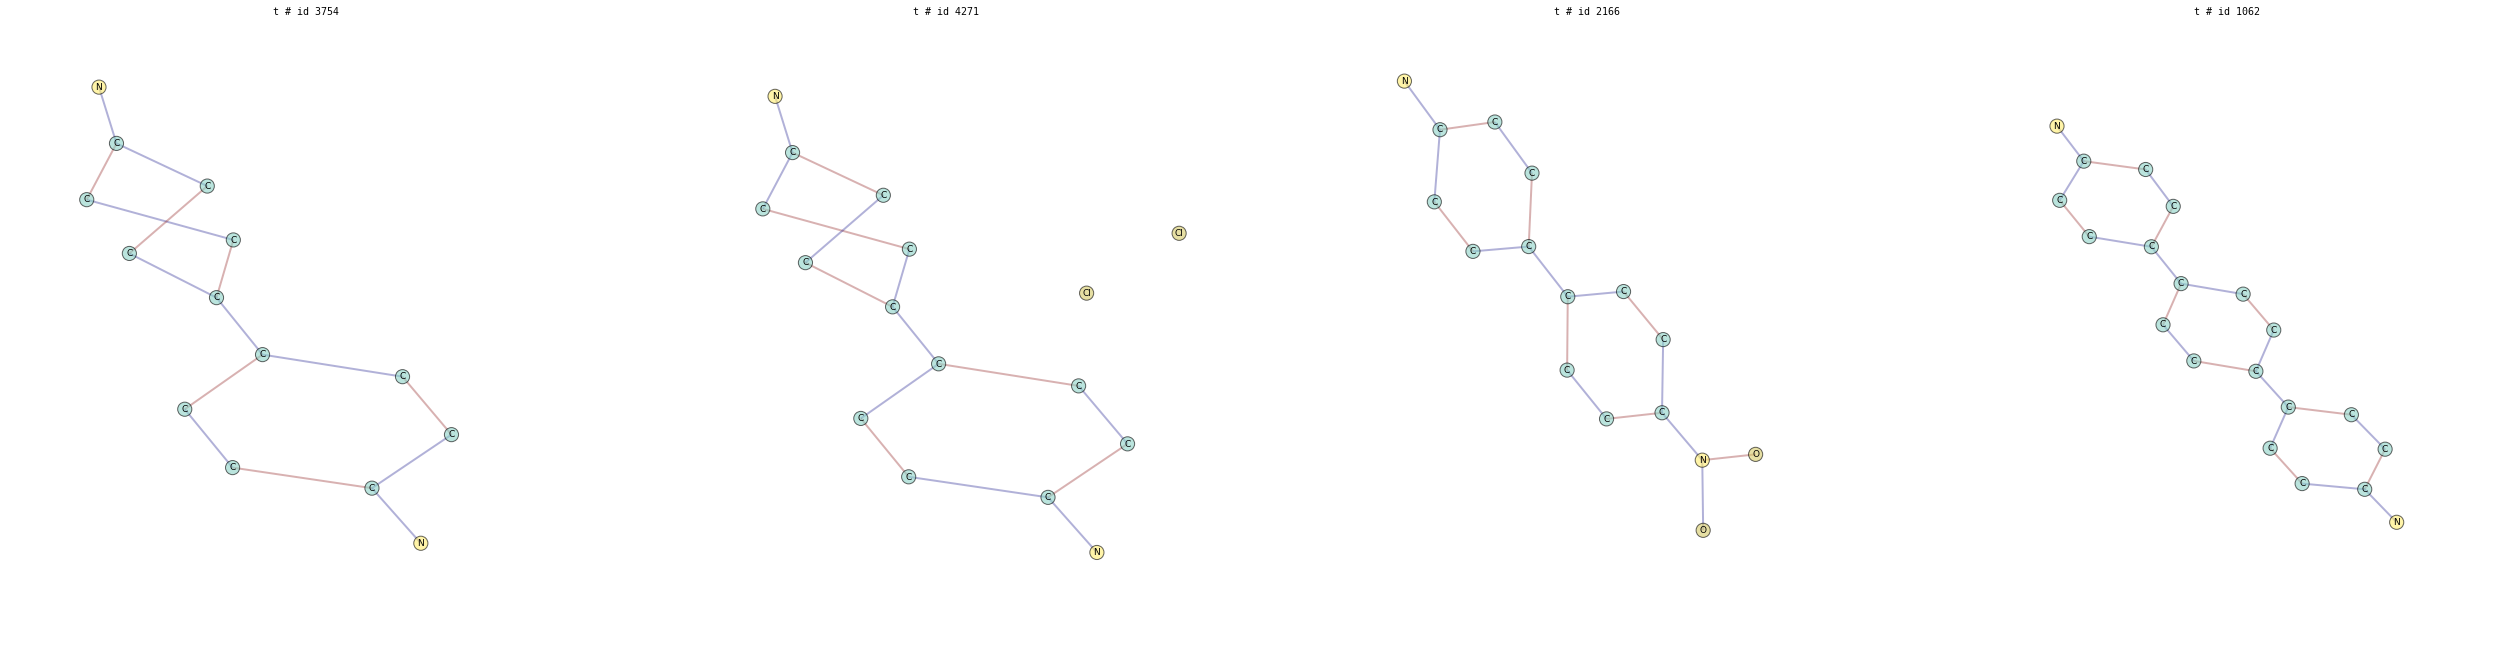

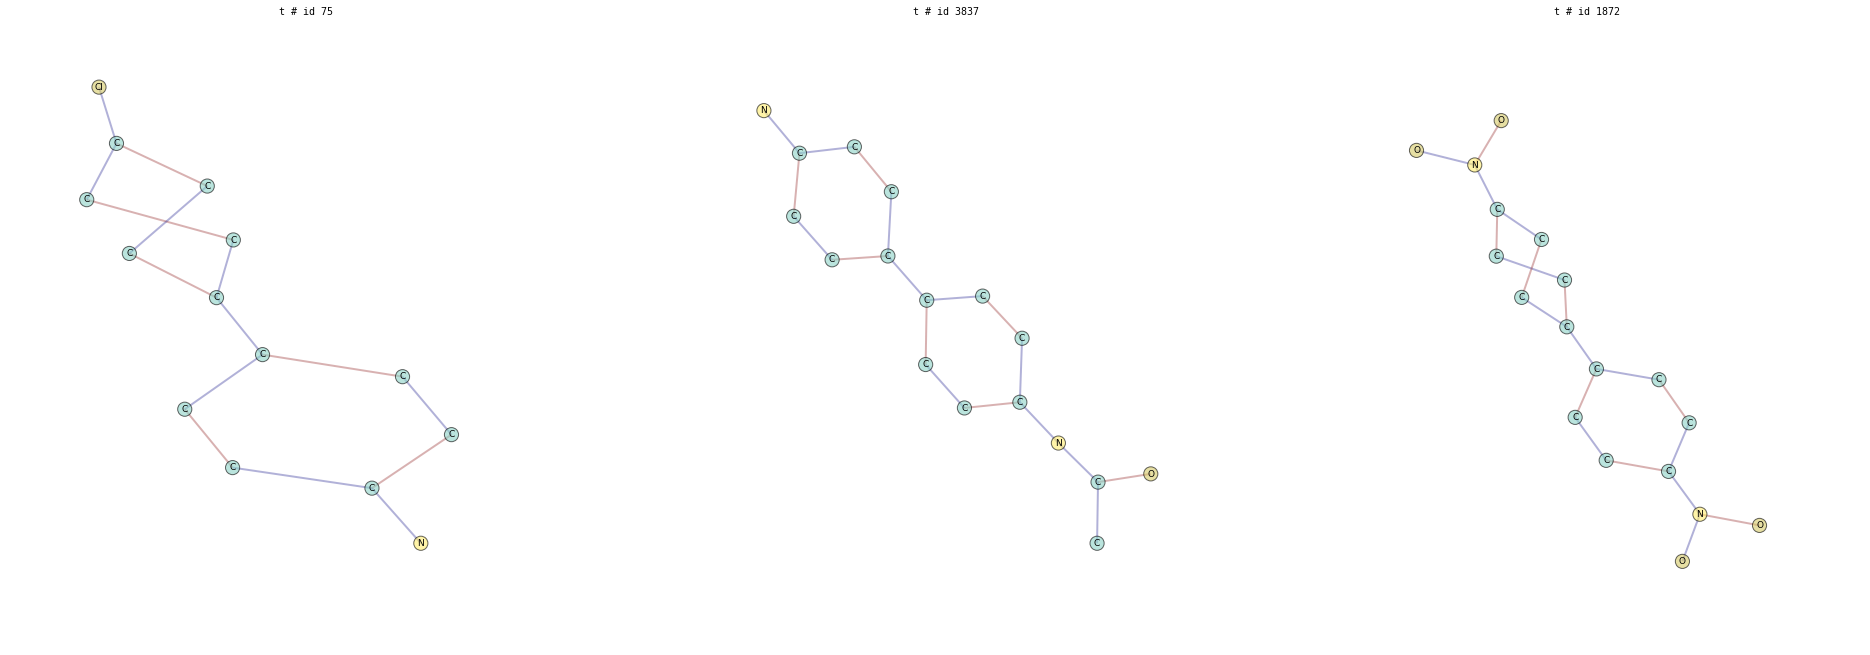

--------------------------------------------------------------------------------
cluster:8 size:13


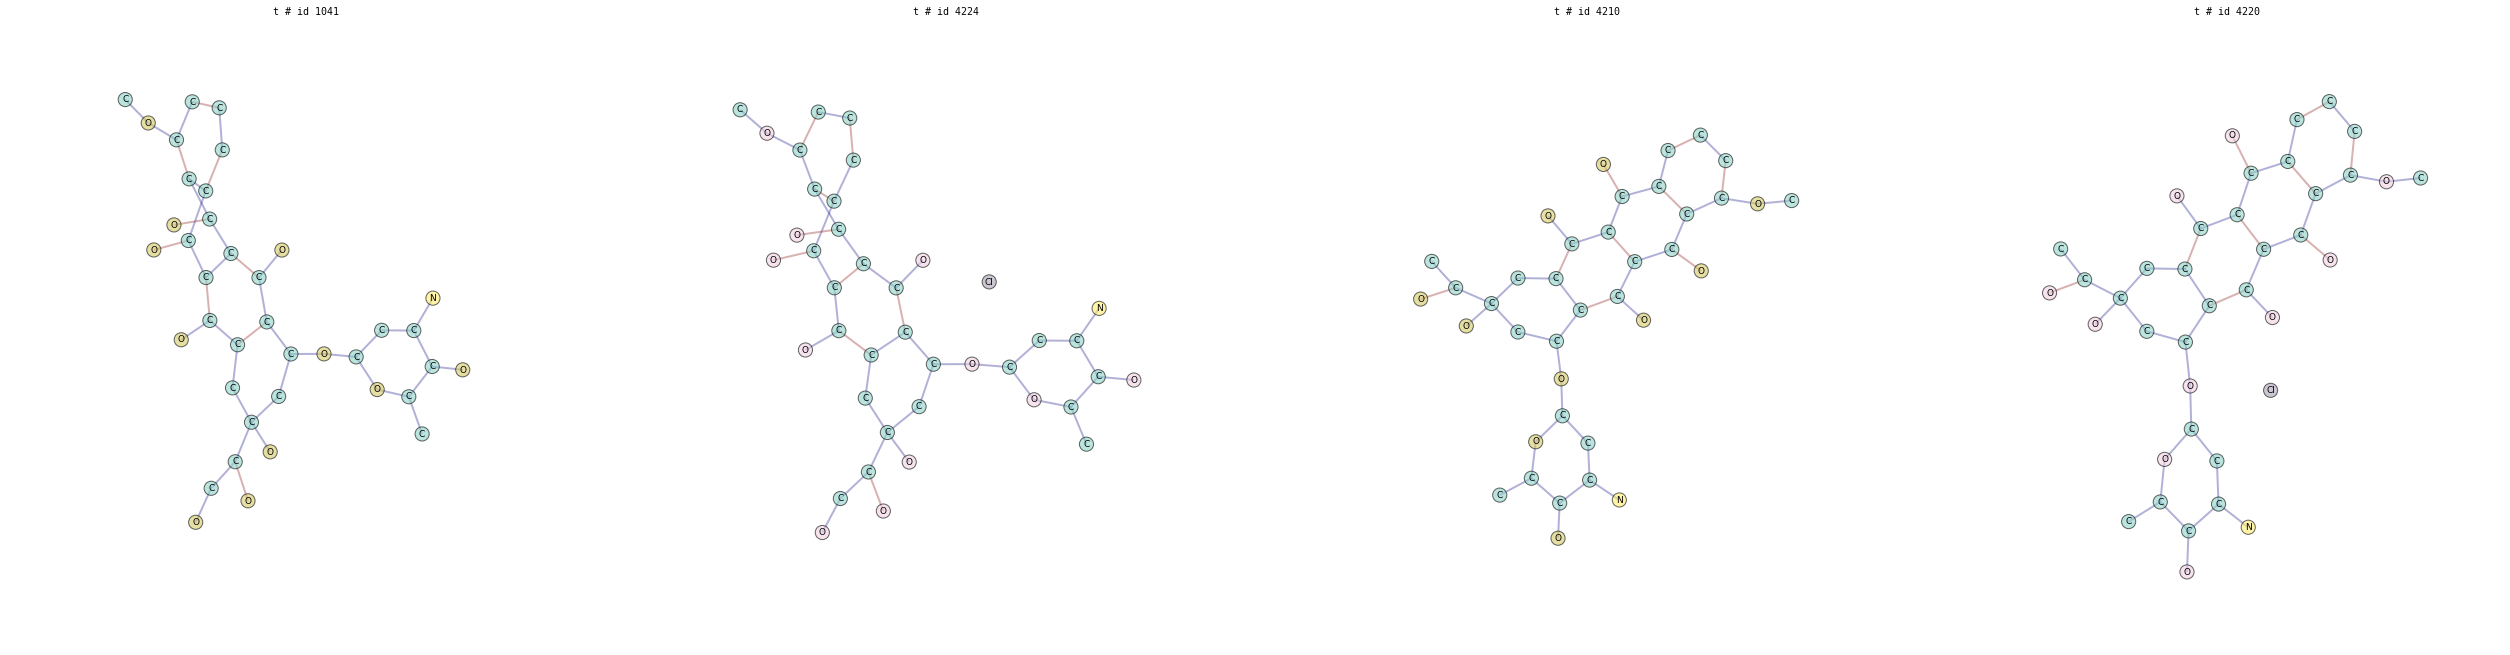

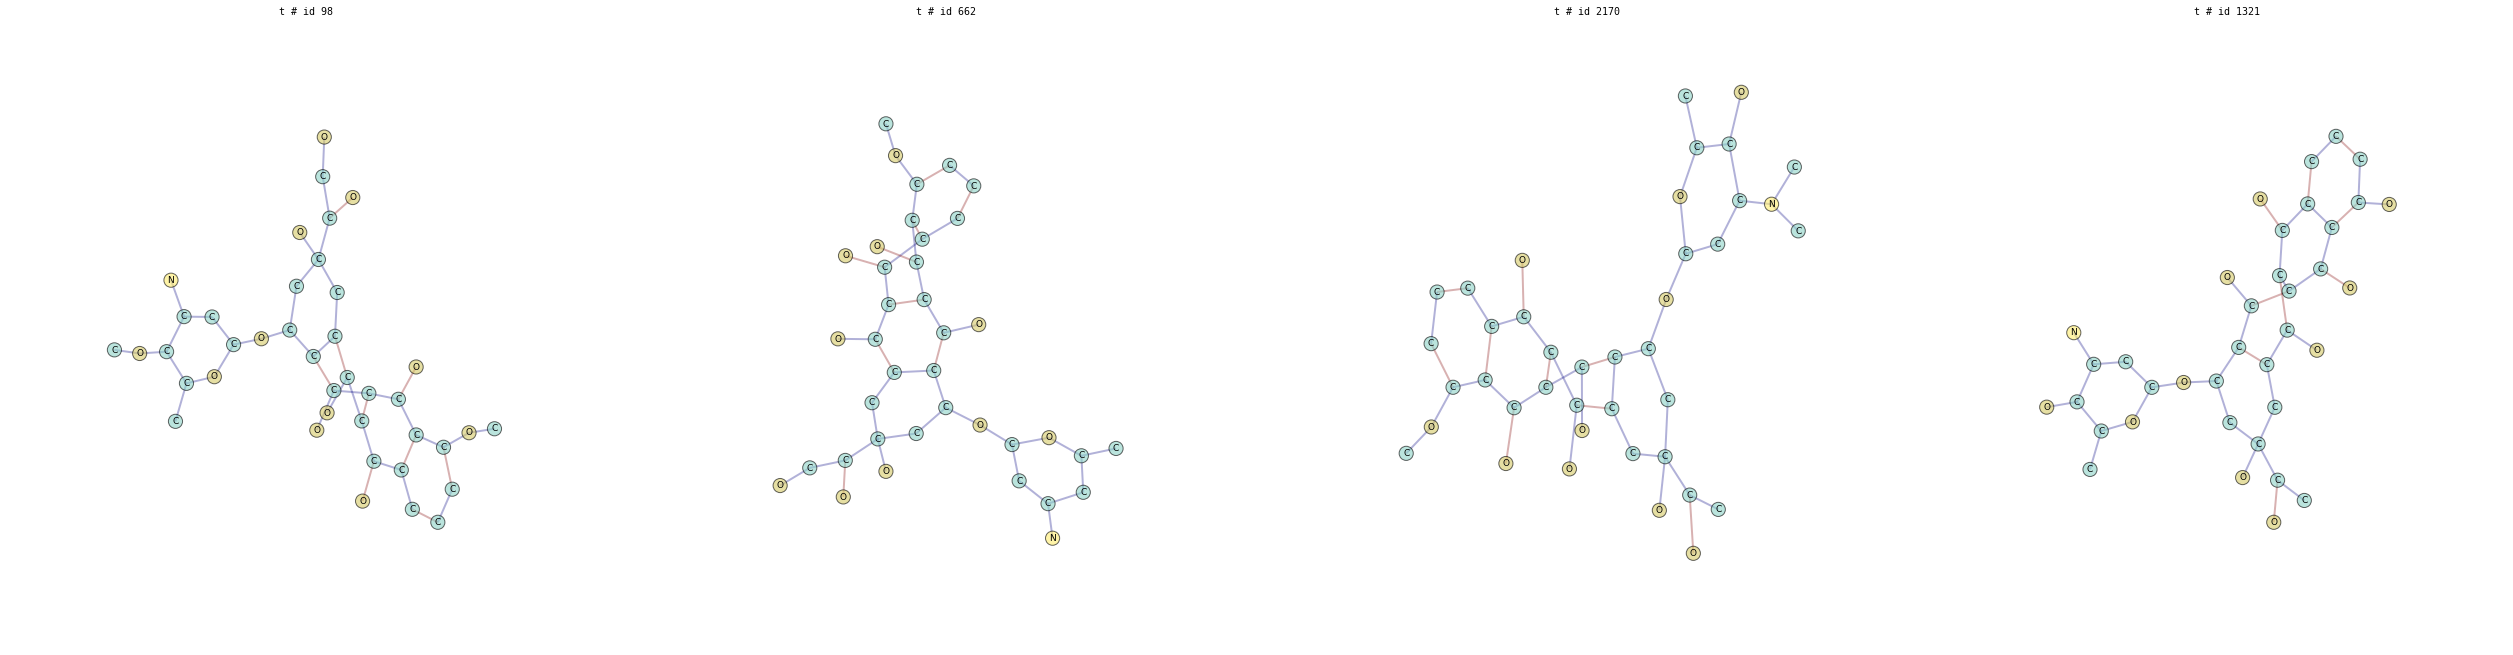

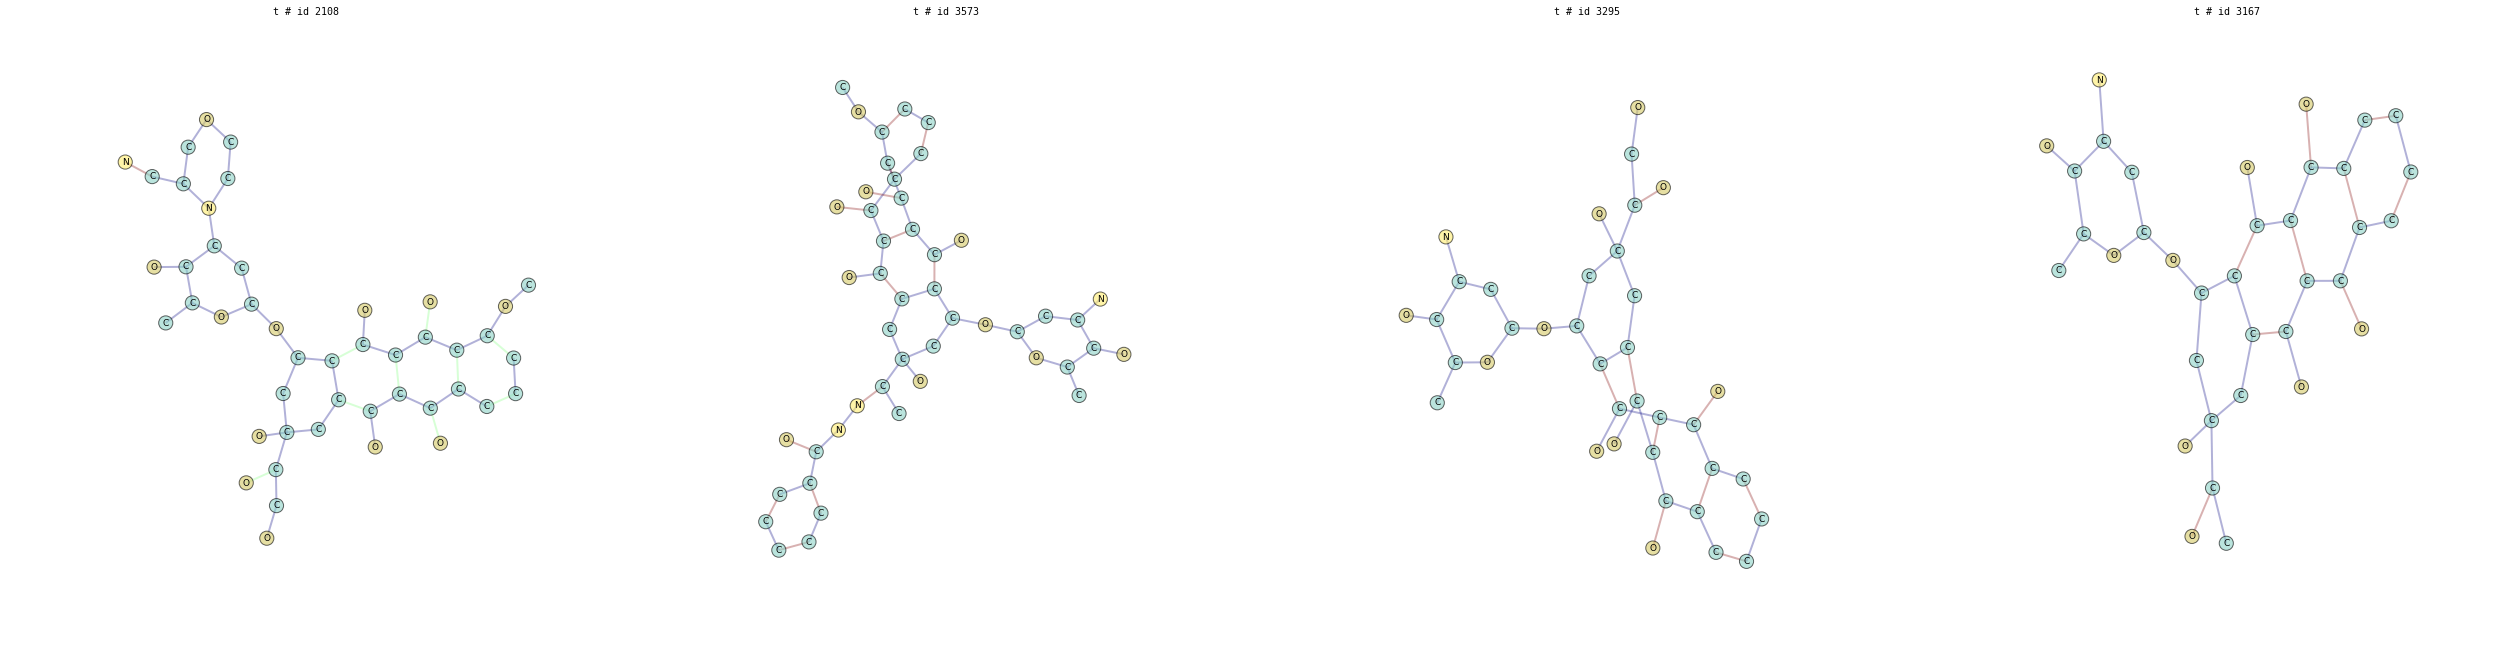

--------------------------------------------------------------------------------
cluster:9 size:11


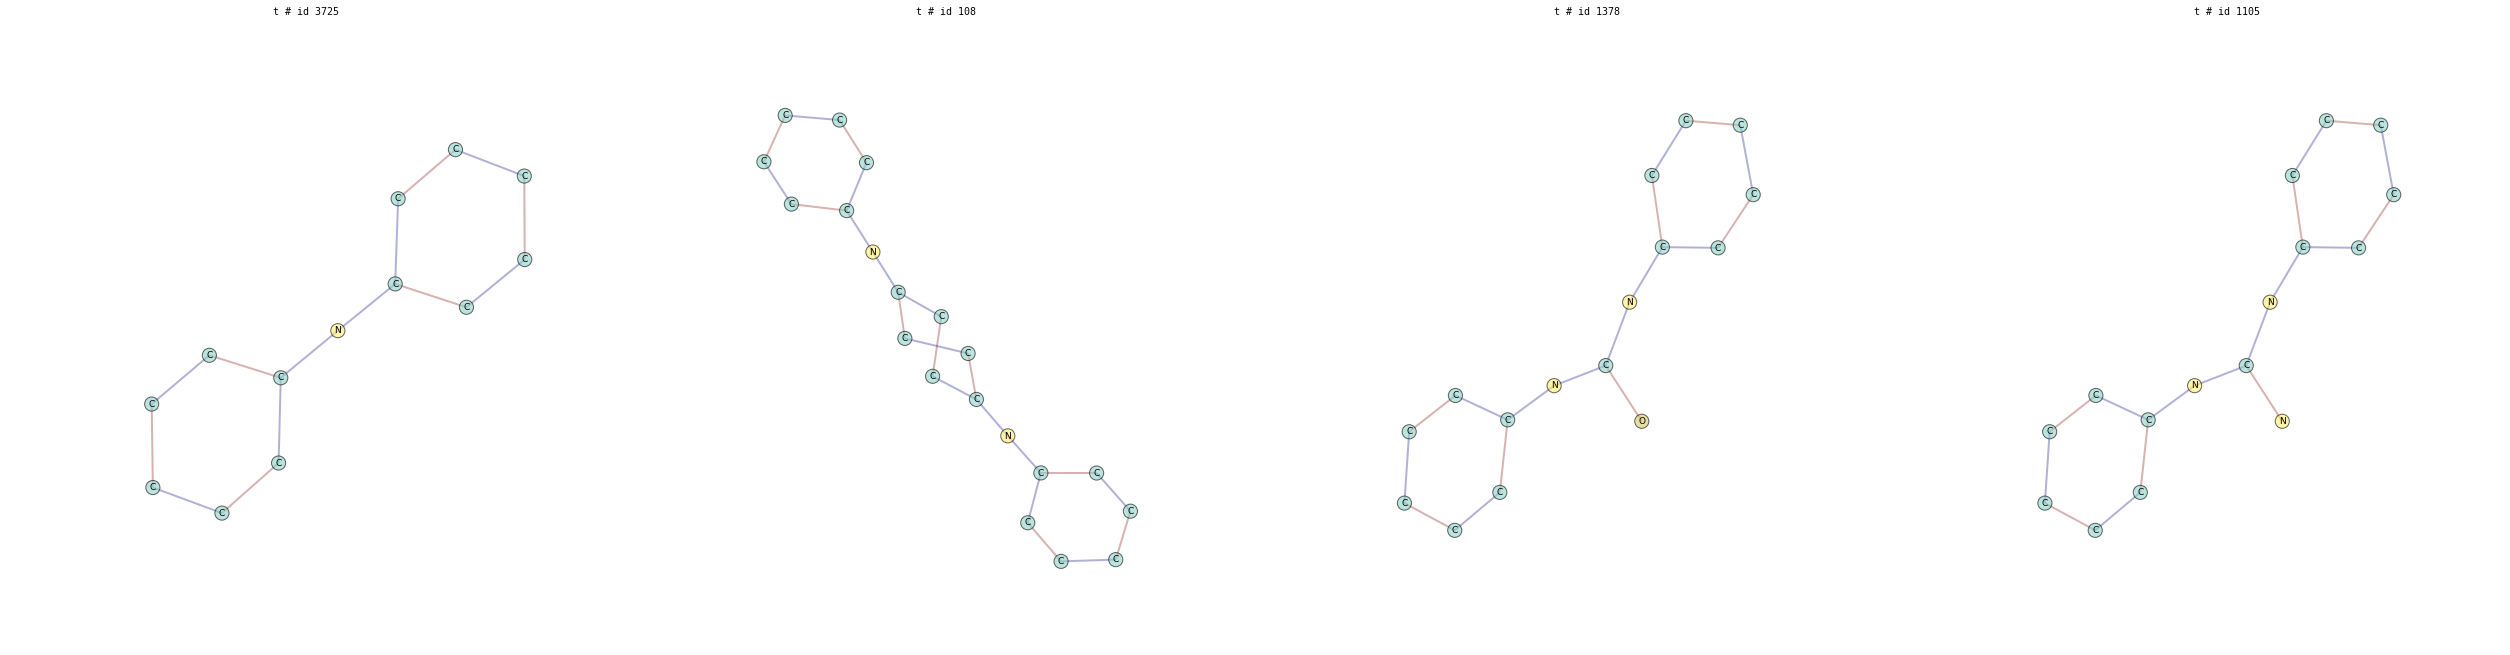

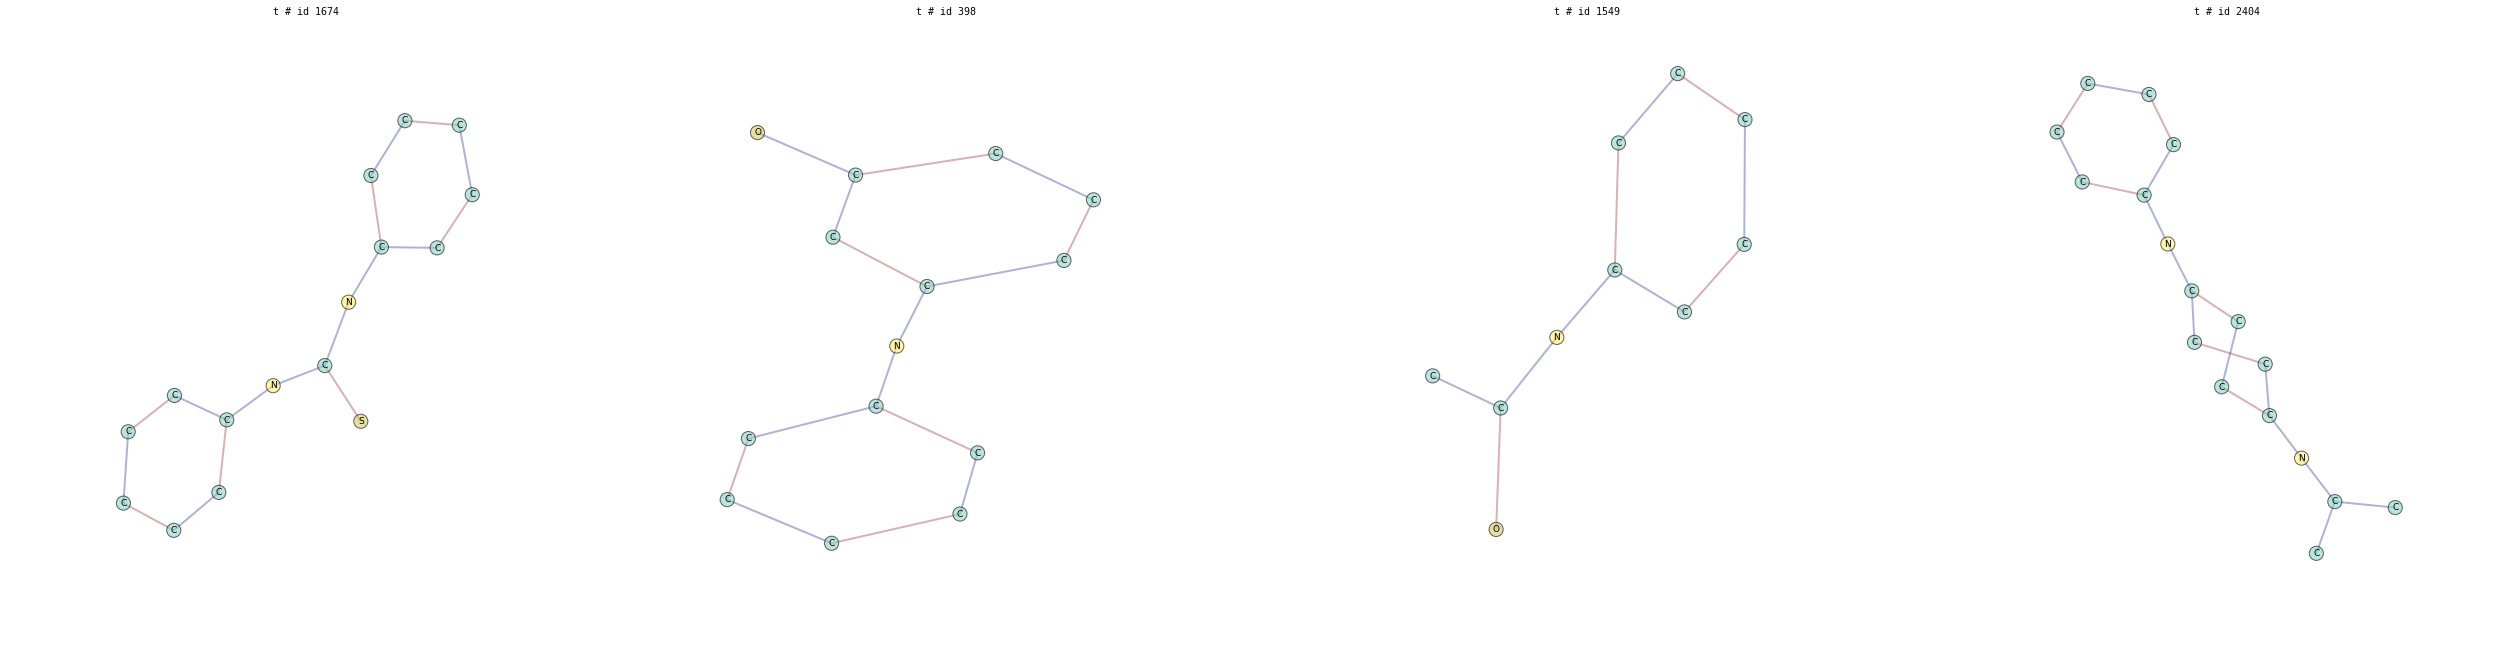

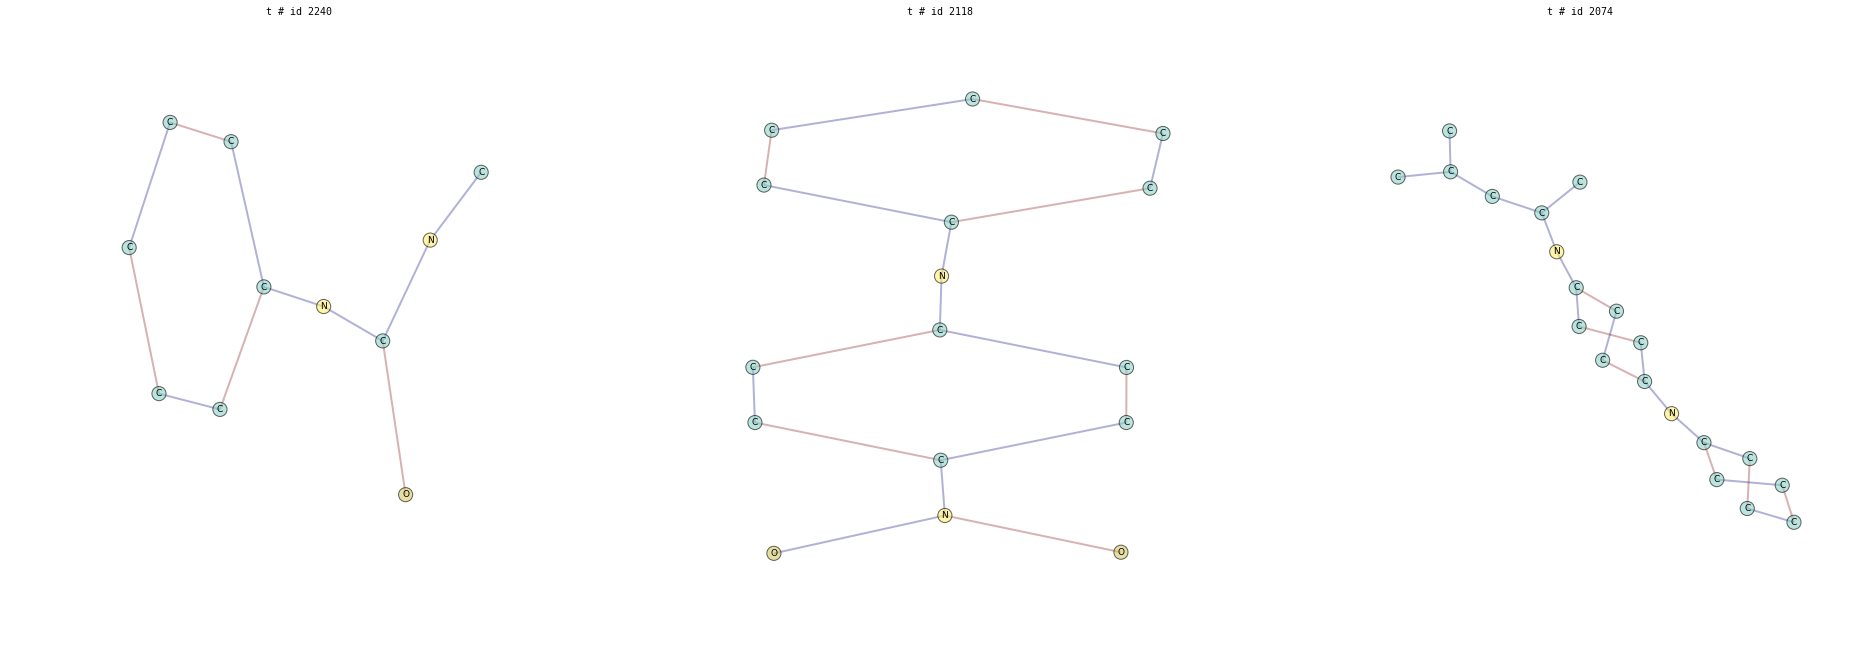

--------------------------------------------------------------------------------
cluster:10 size:6


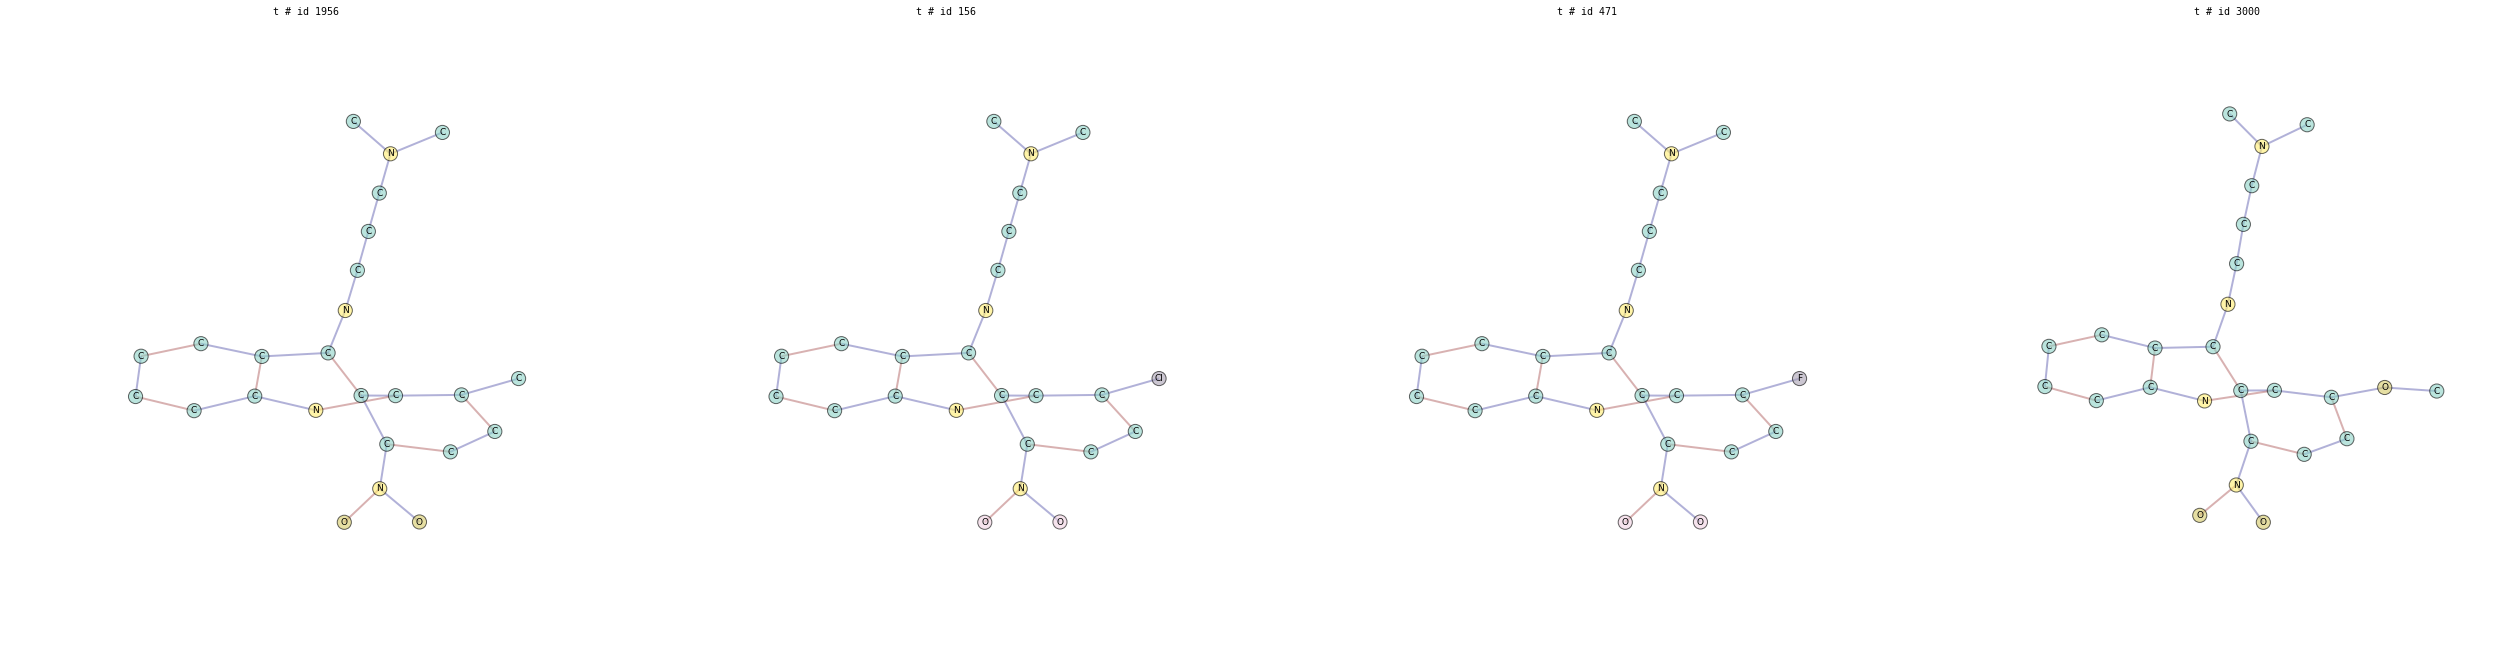

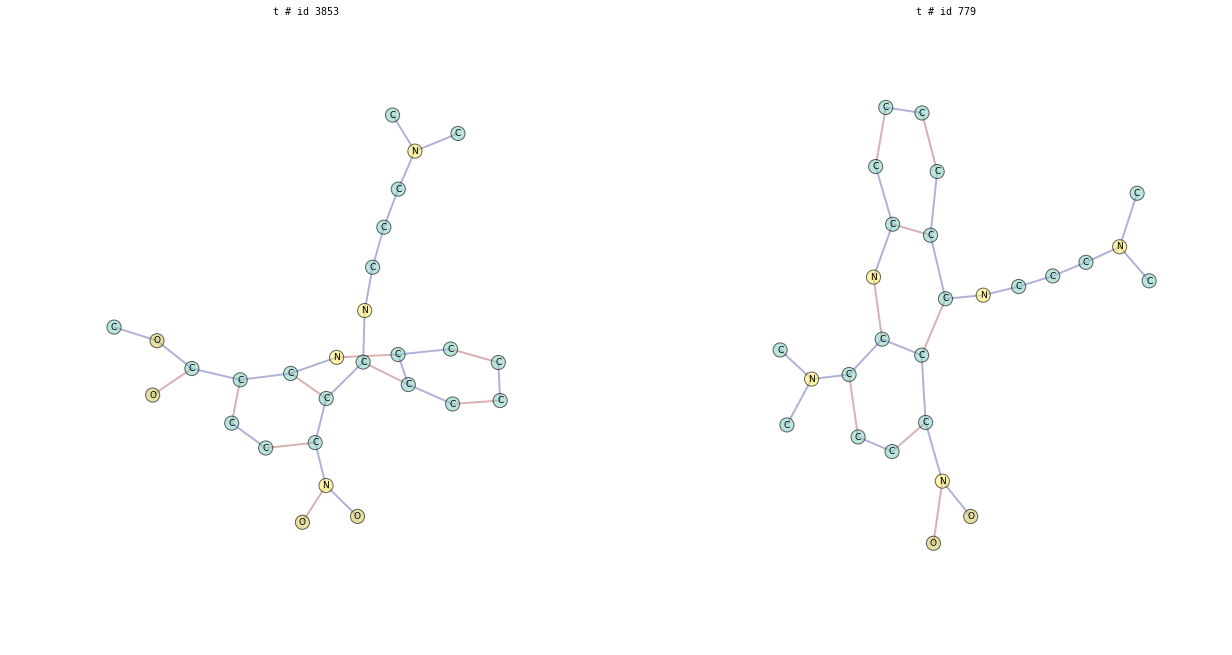

--------------------------------------------------------------------------------
cluster:11 size:6


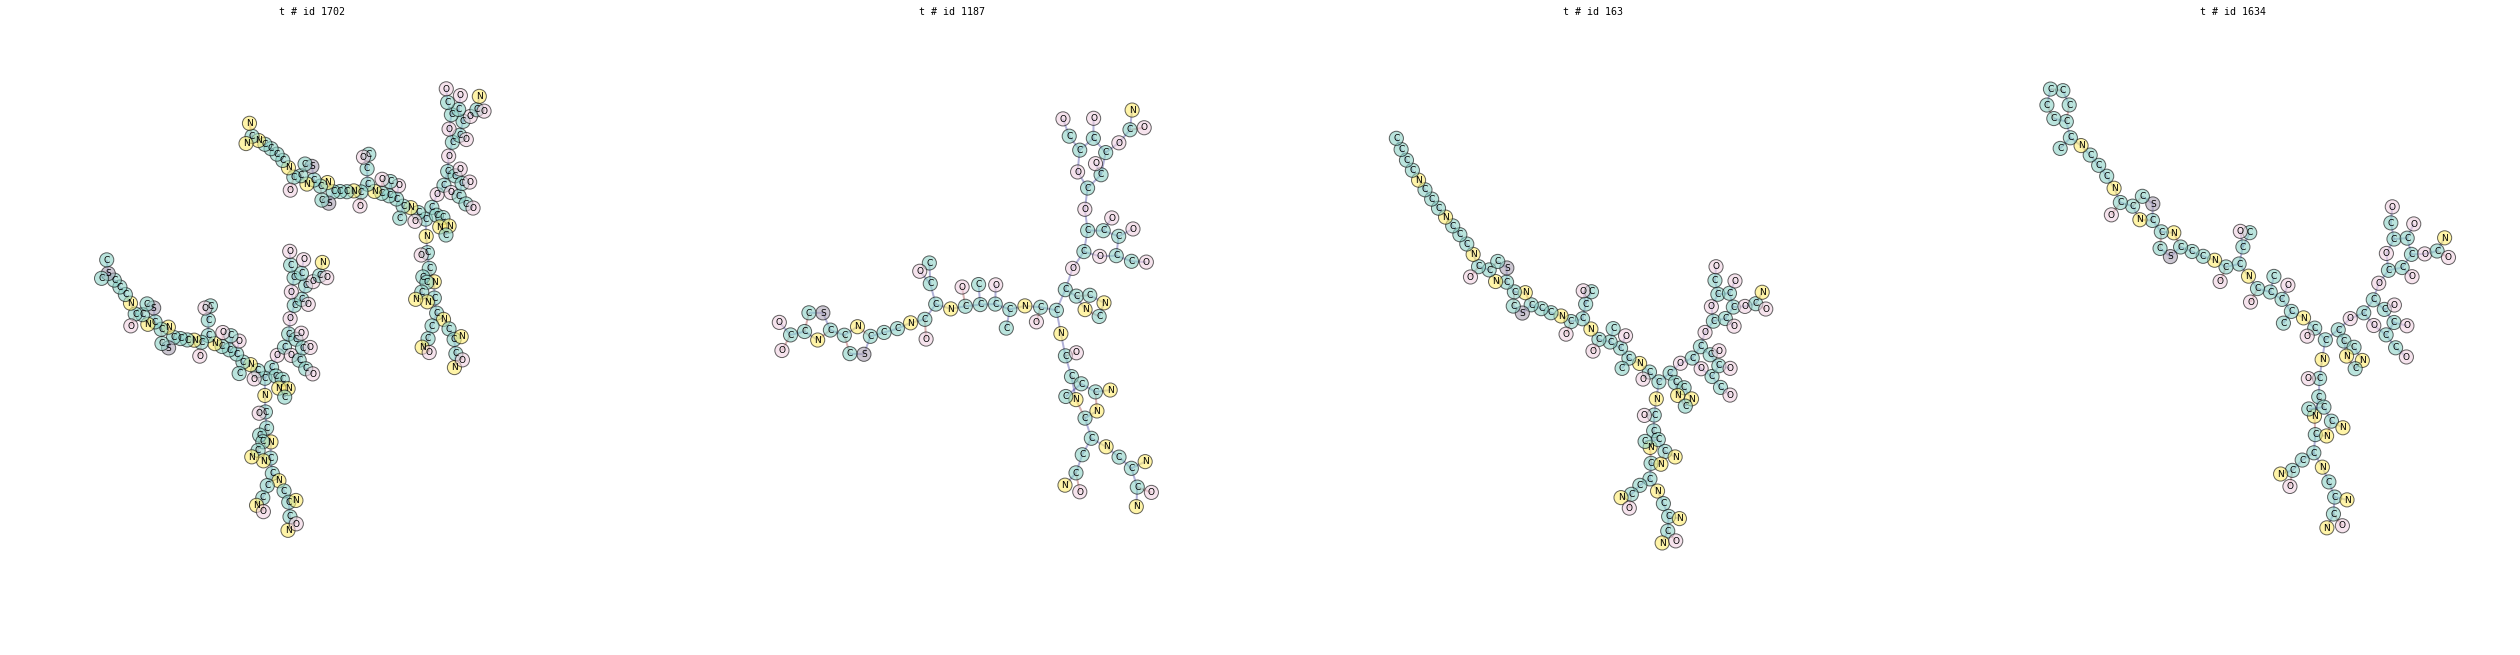

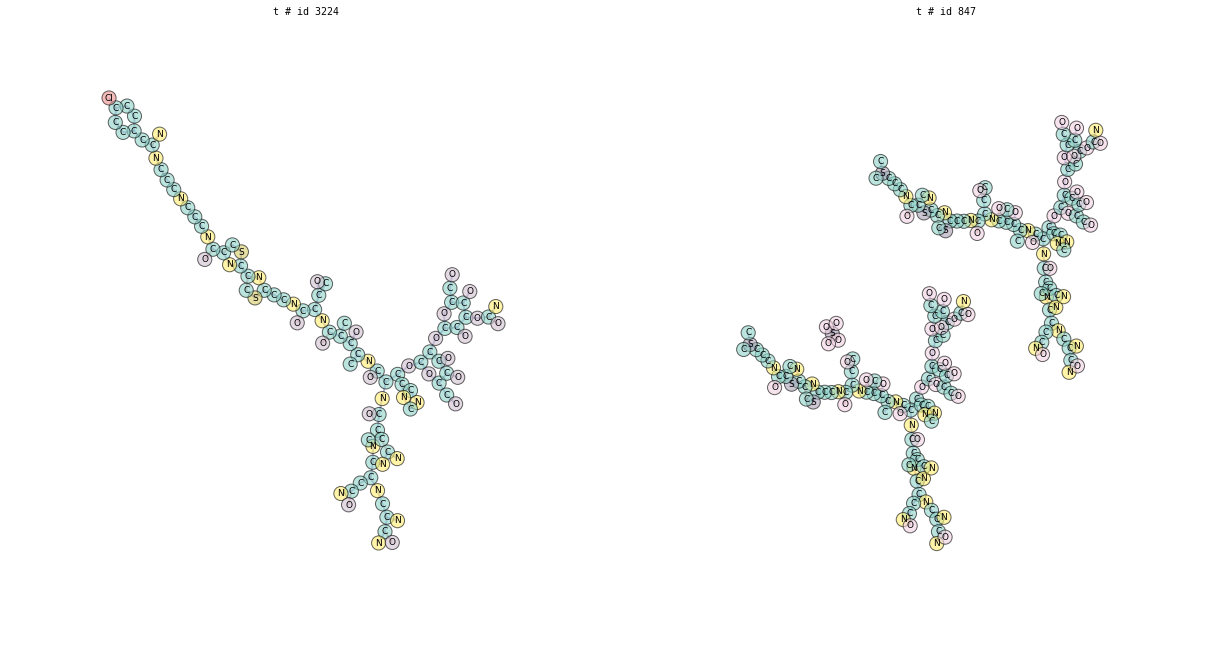

--------------------------------------------------------------------------------
cluster:12 size:6


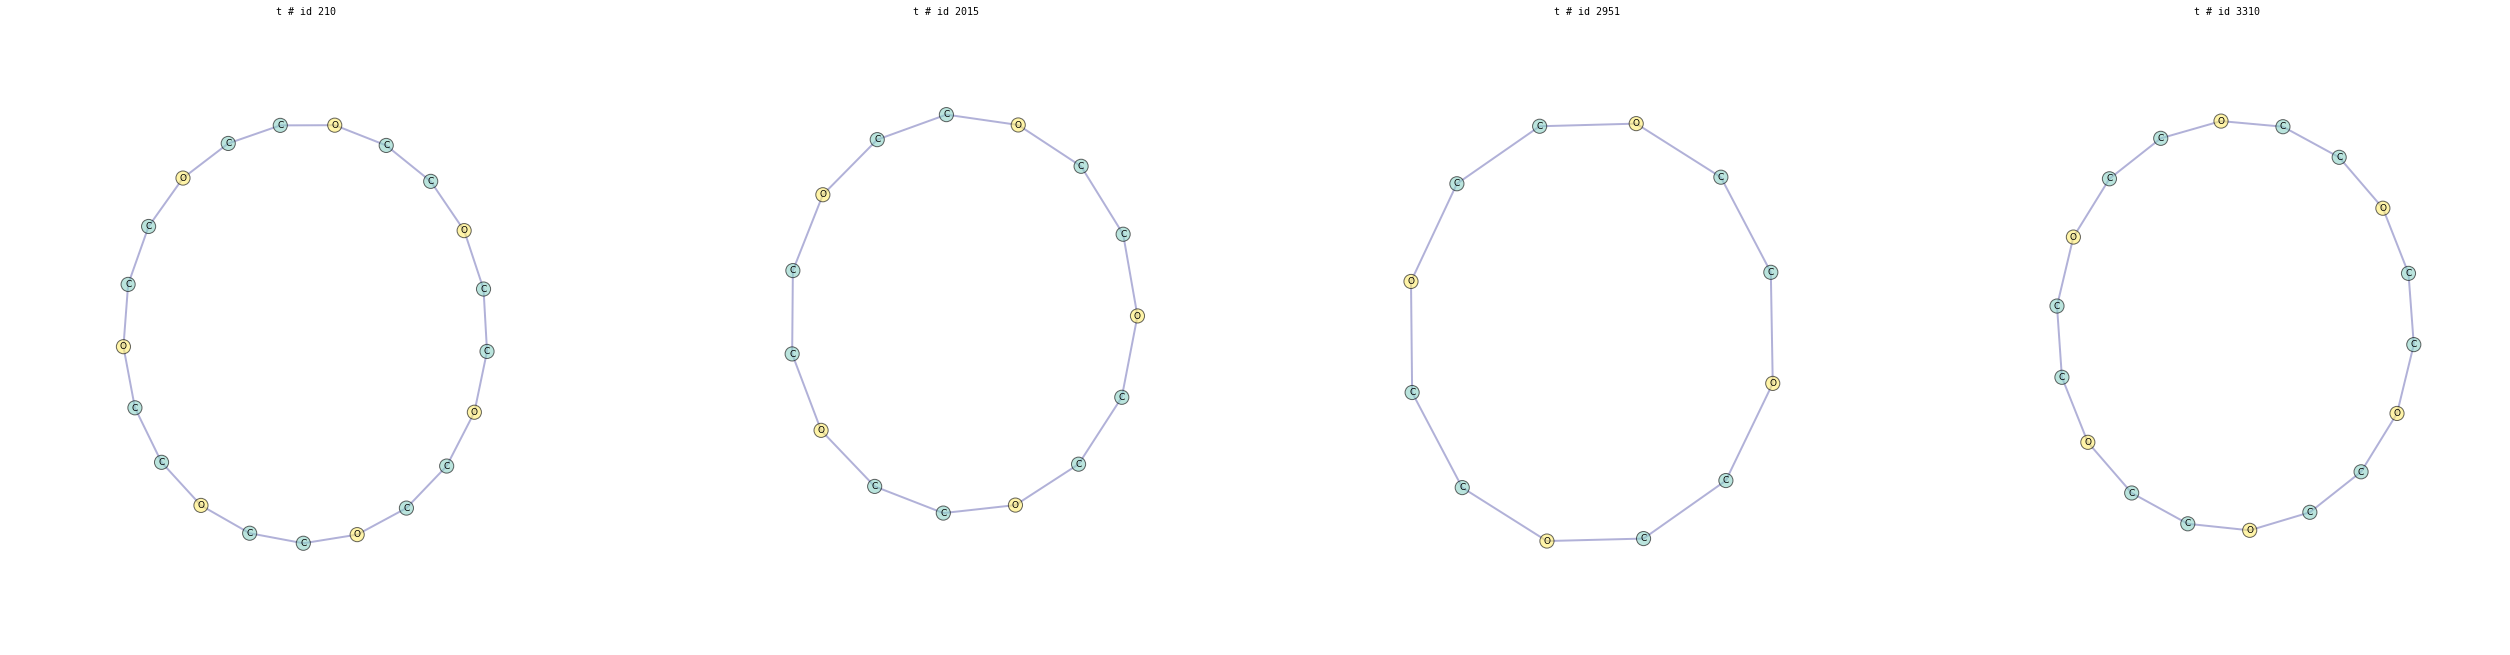

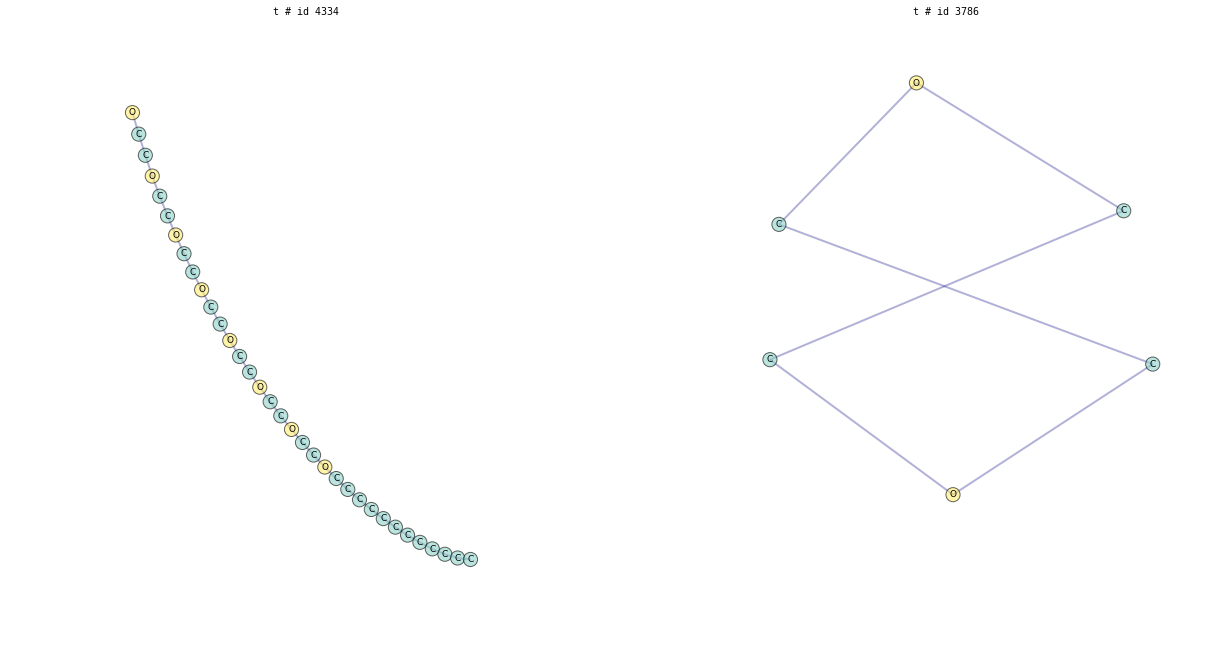

--------------------------------------------------------------------------------
cluster:13 size:20


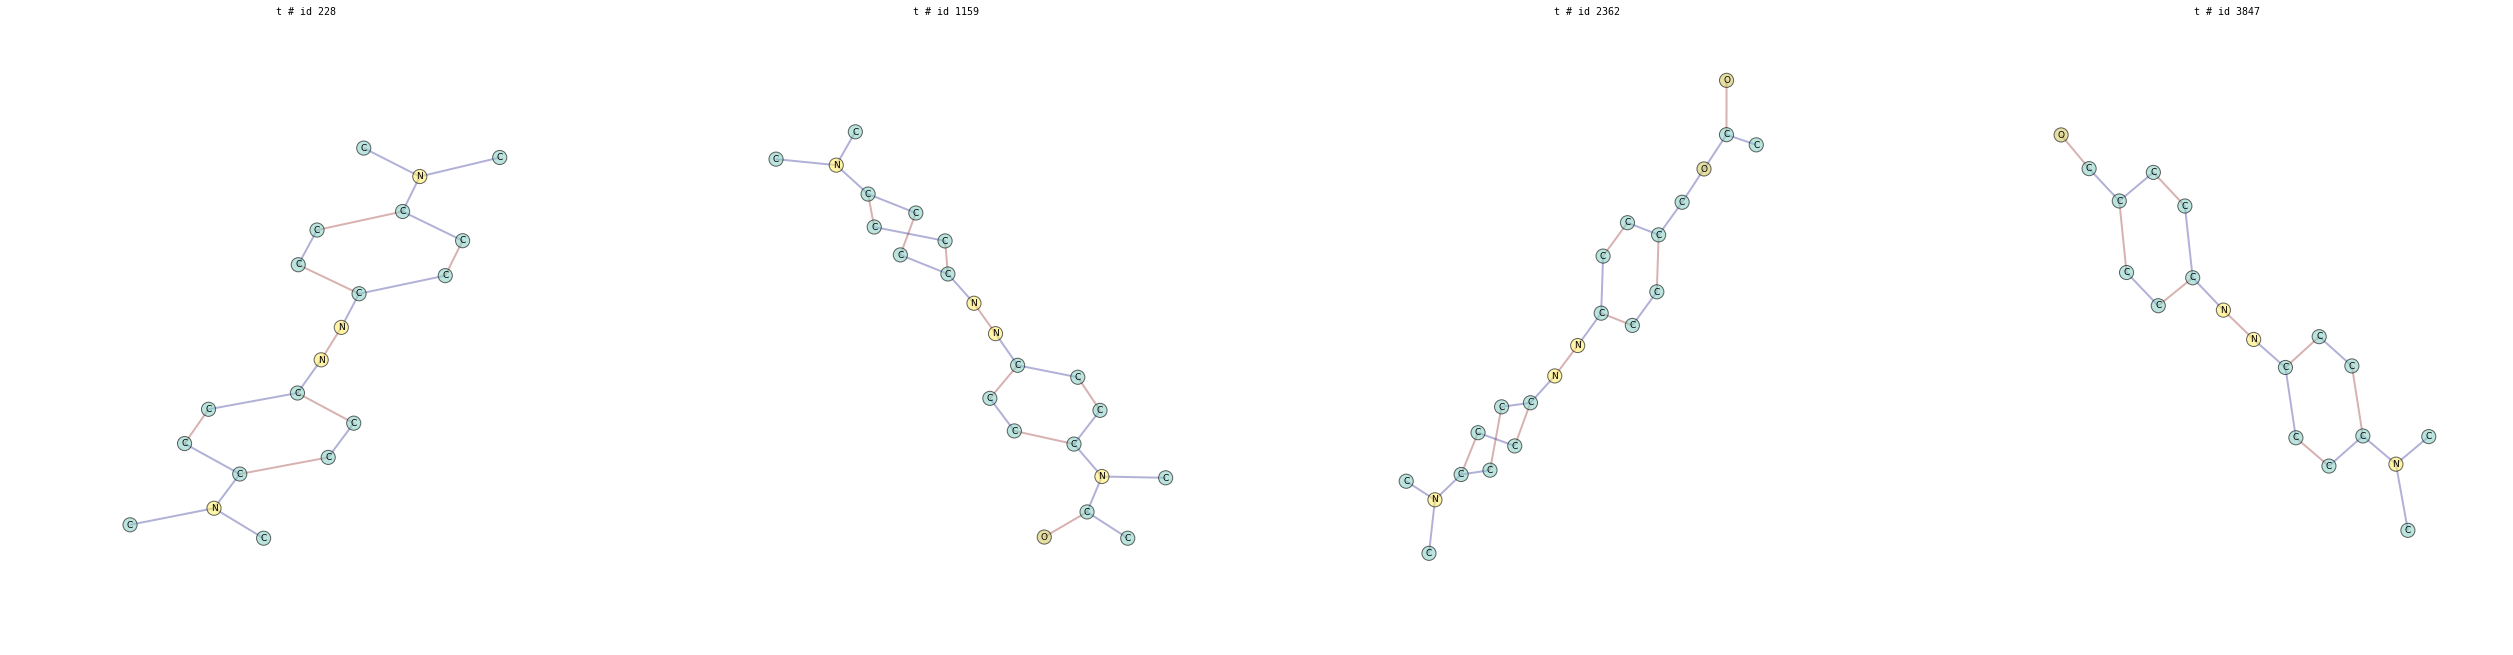

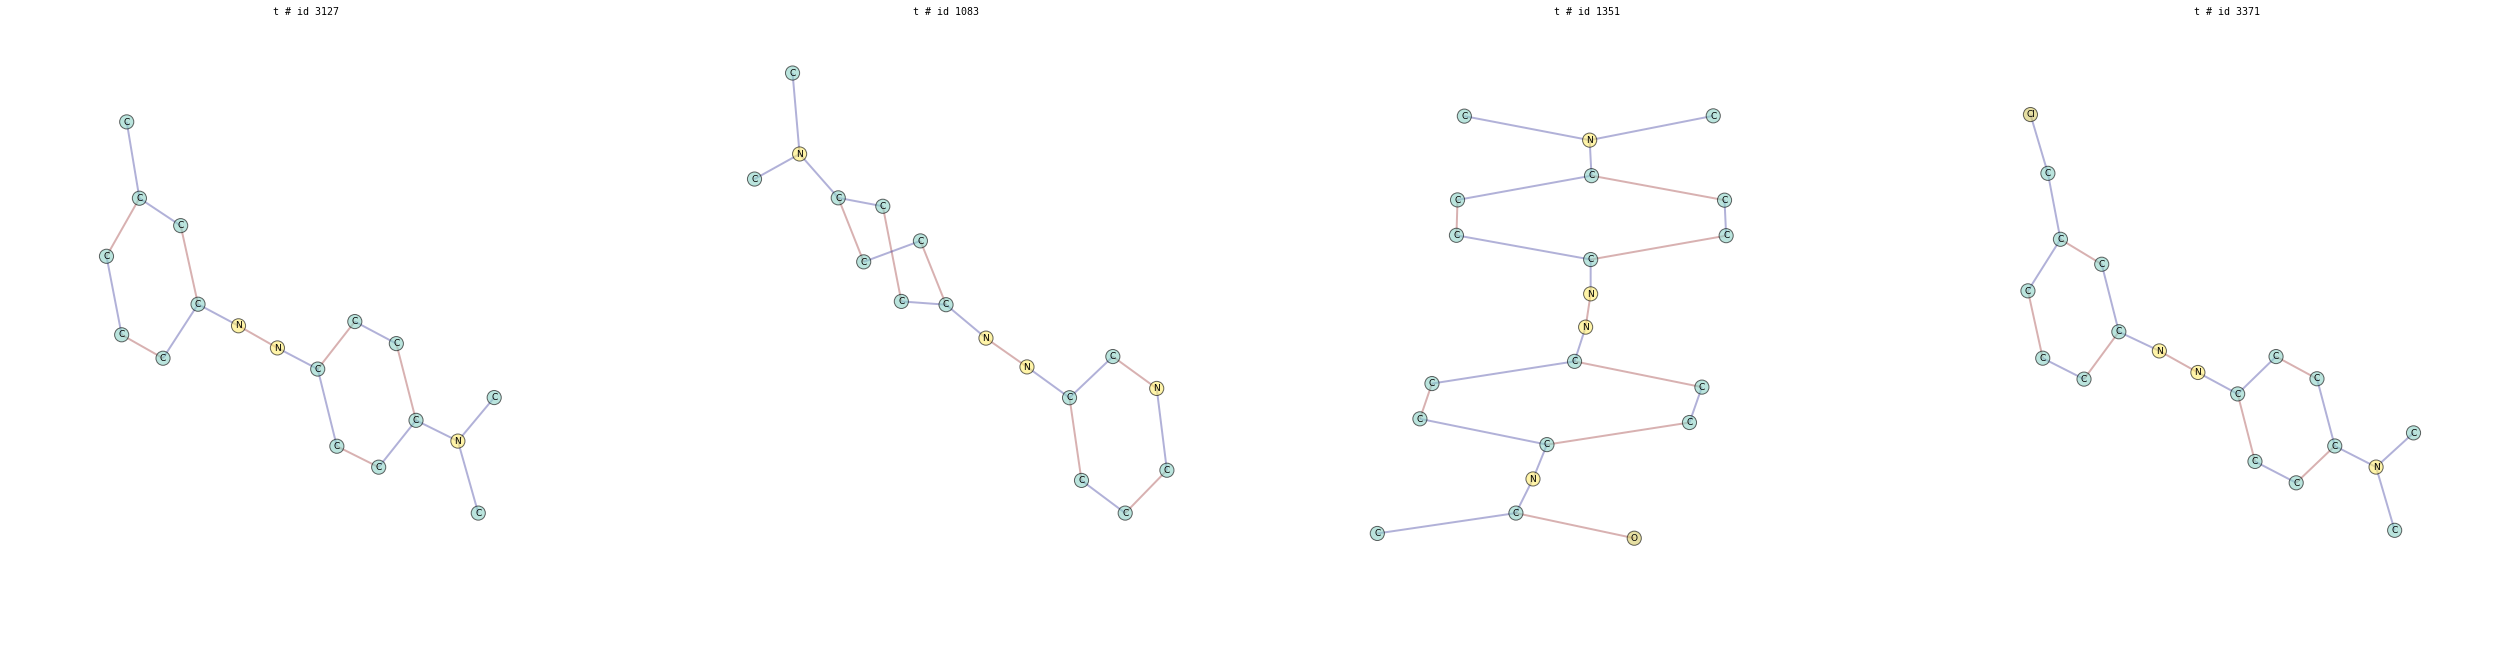

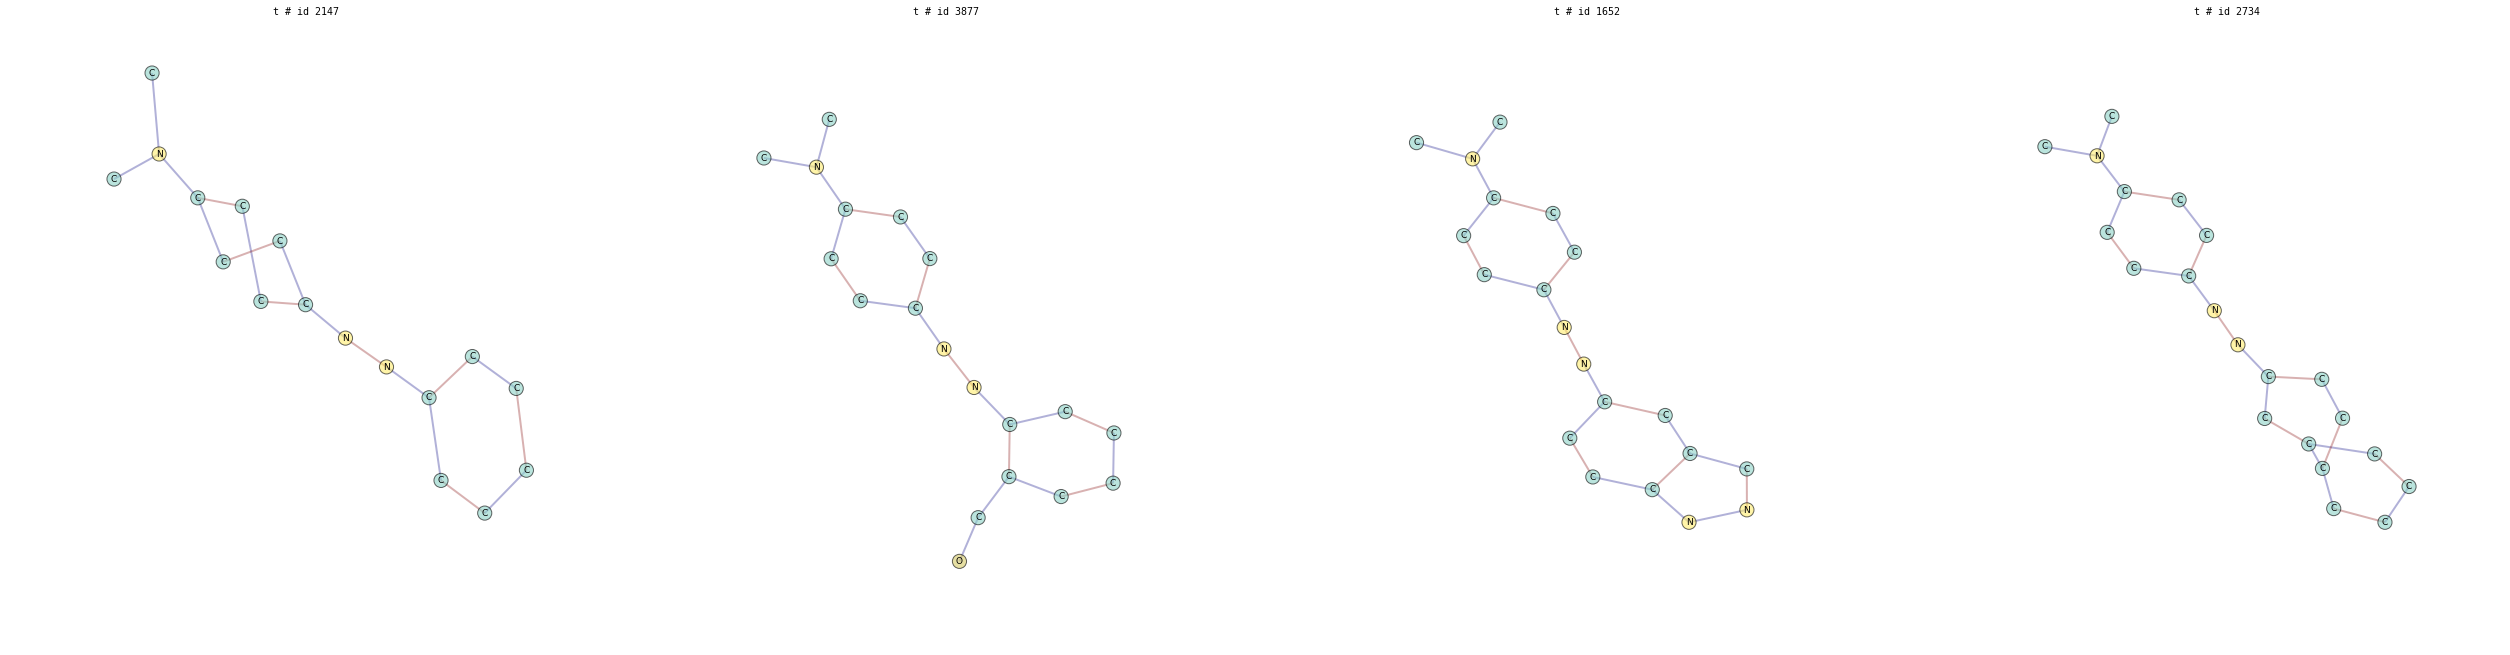

--------------------------------------------------------------------------------
cluster:14 size:9


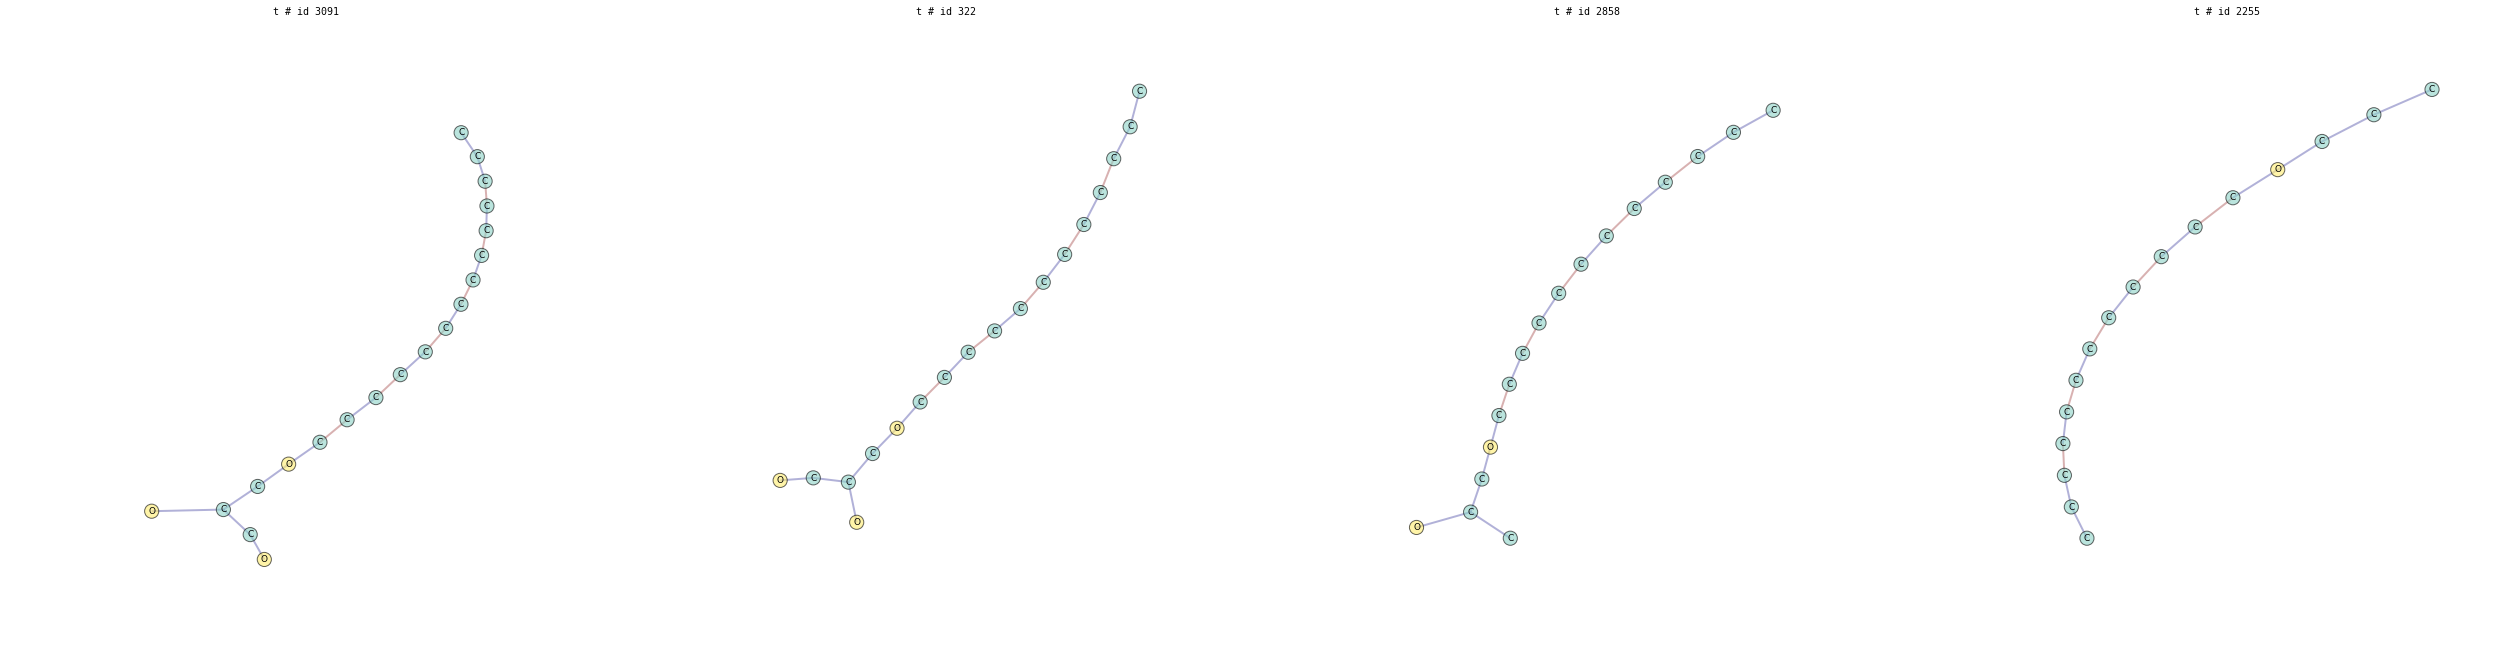

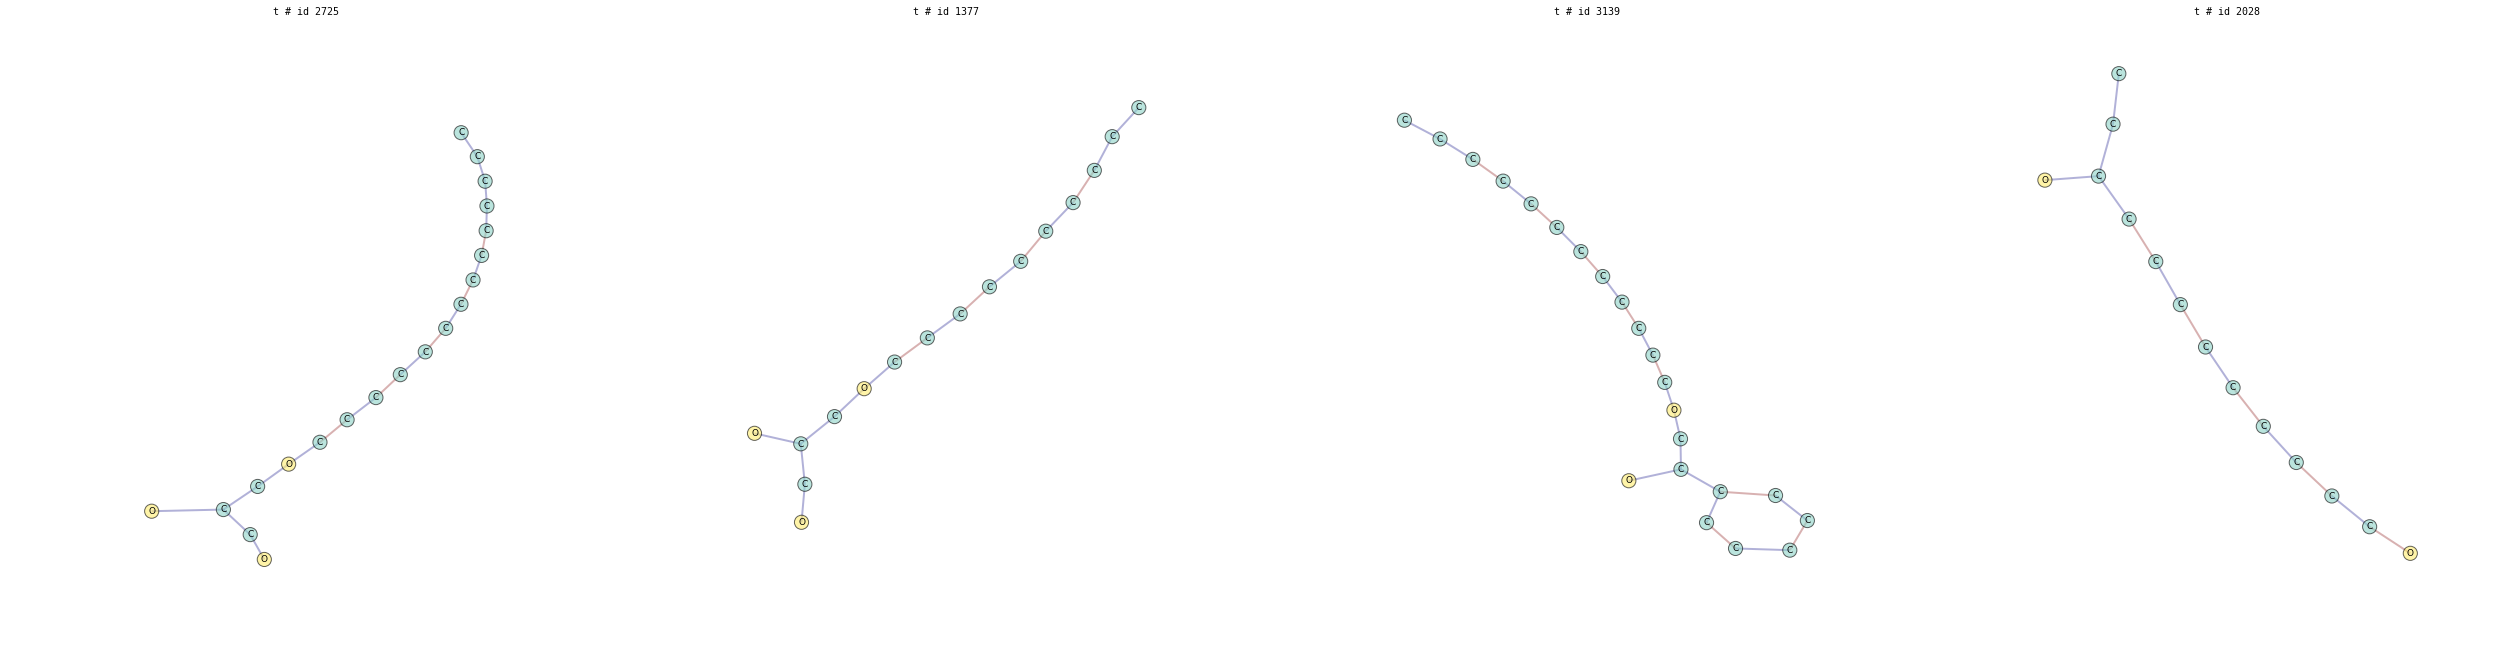

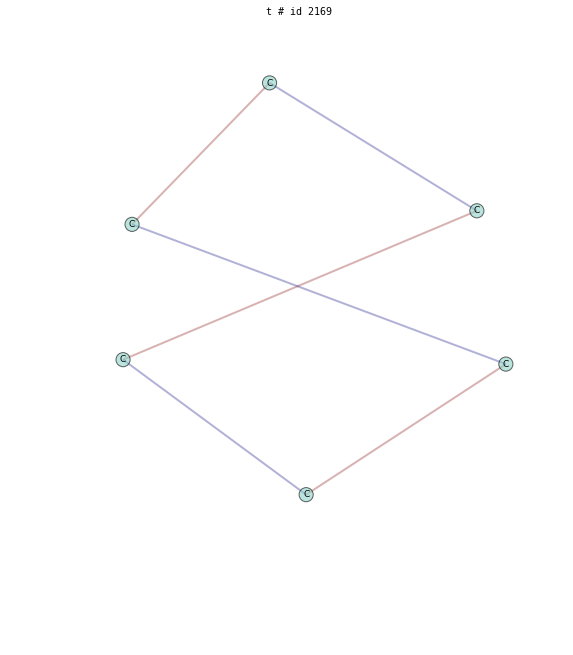

--------------------------------------------------------------------------------
cluster:15 size:6


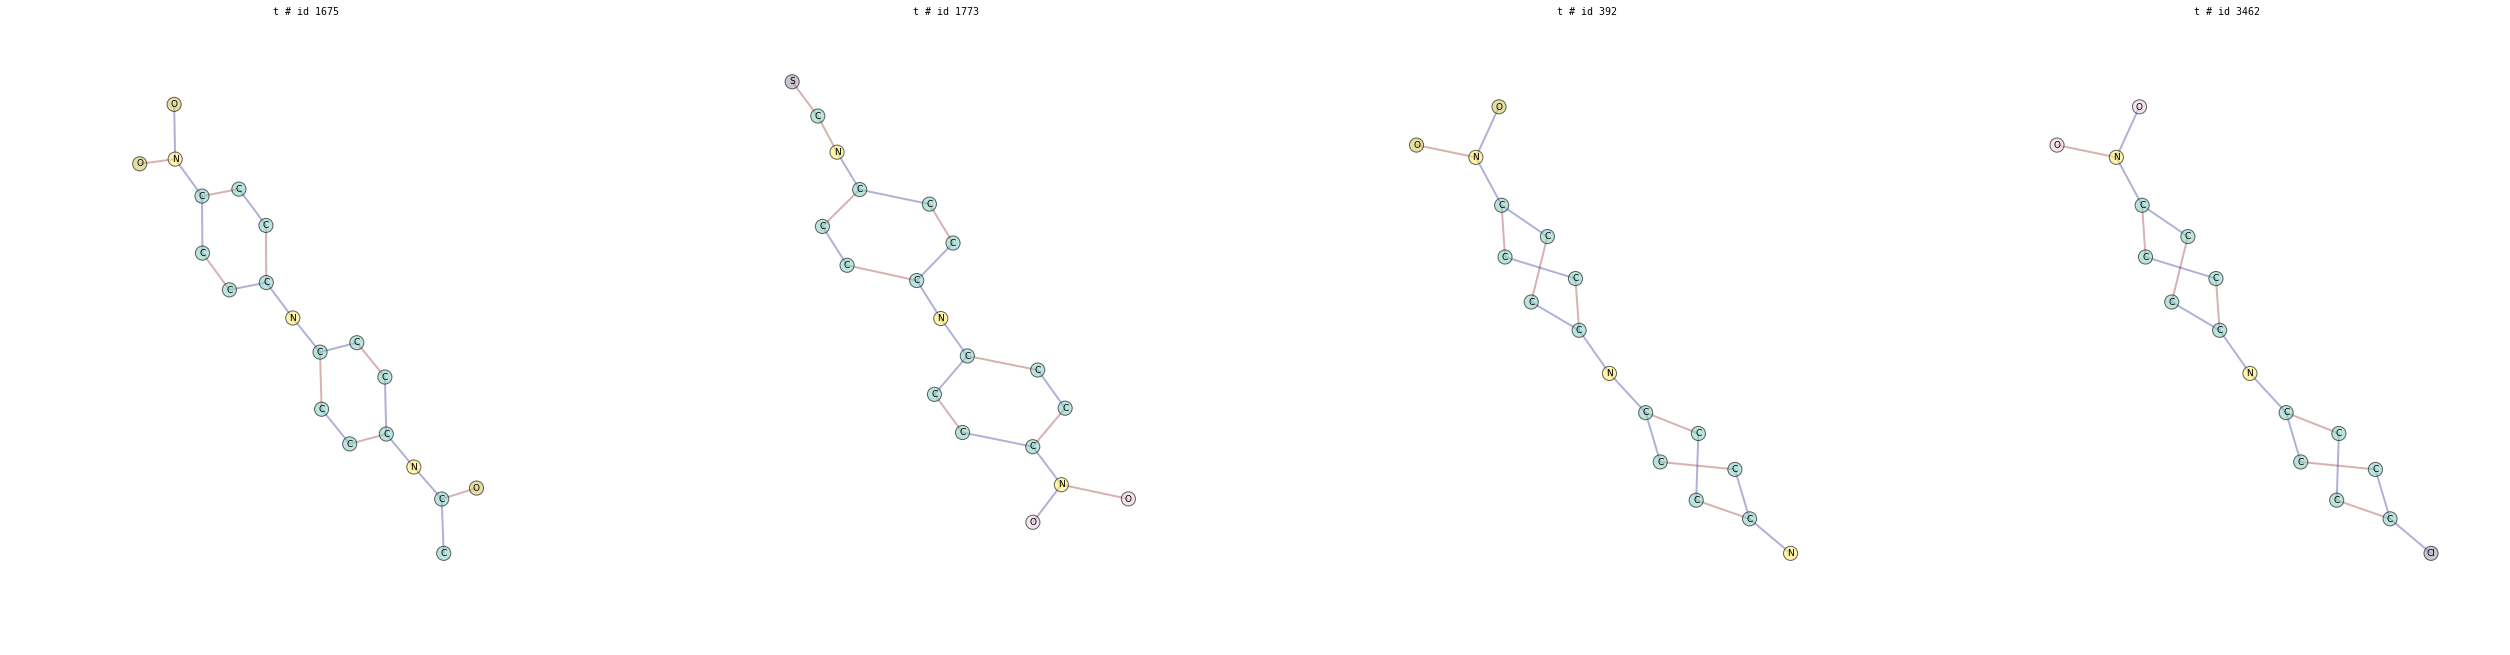

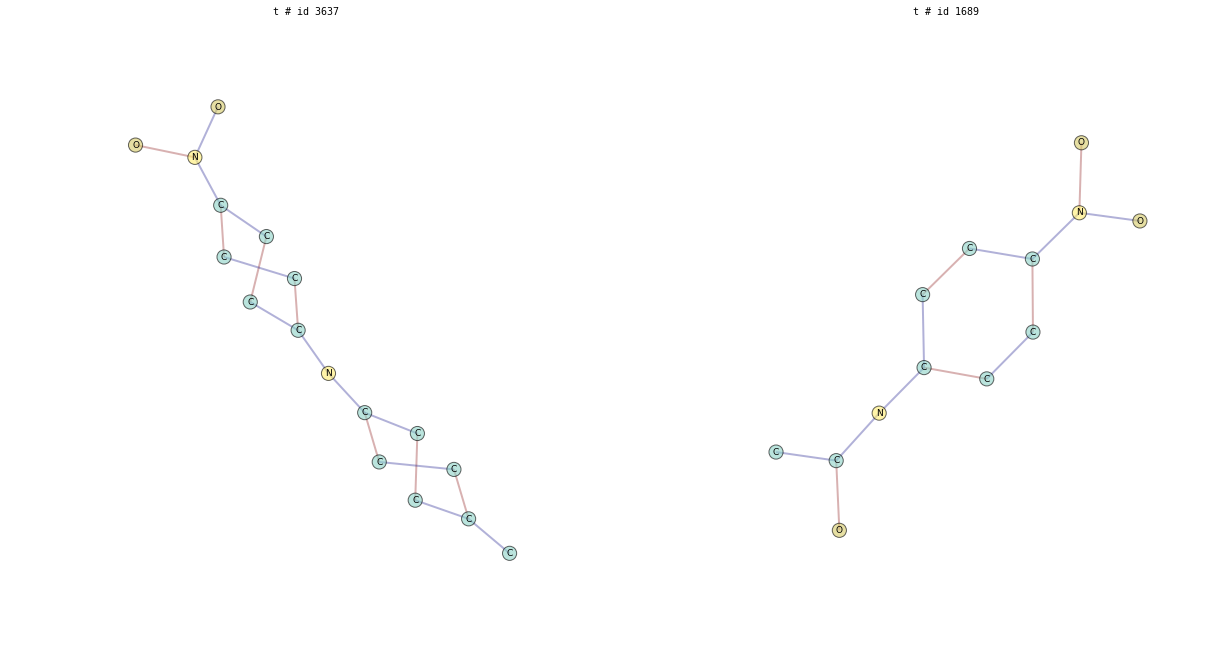

--------------------------------------------------------------------------------
cluster:16 size:8


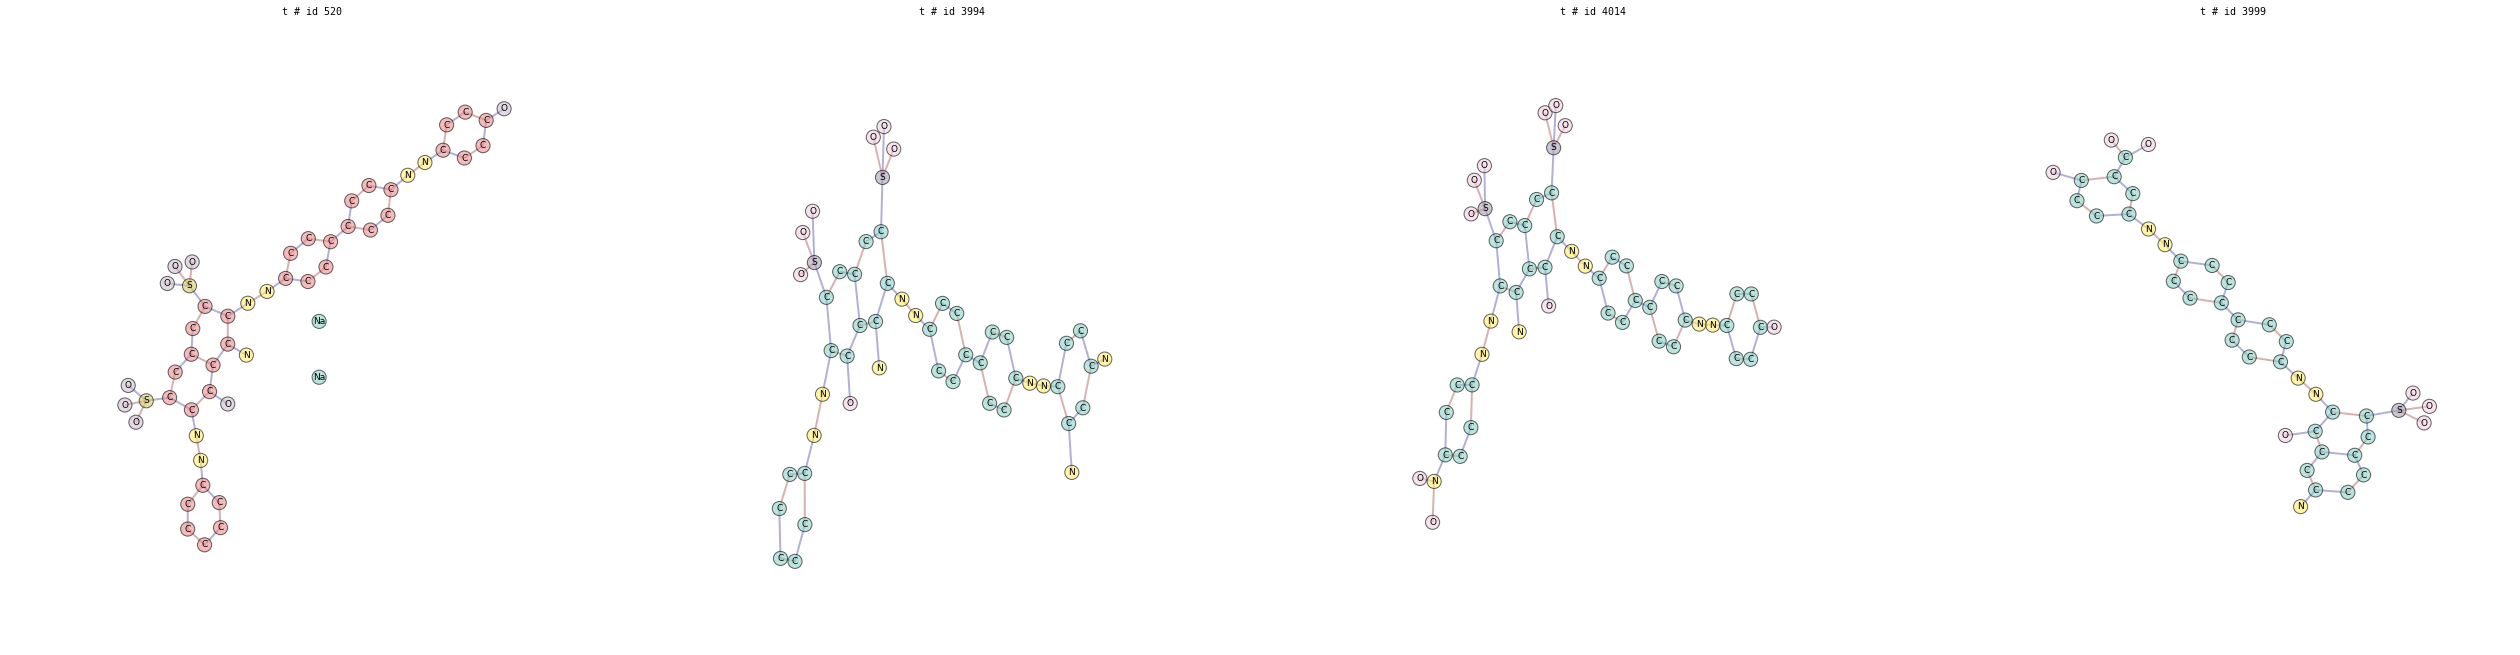

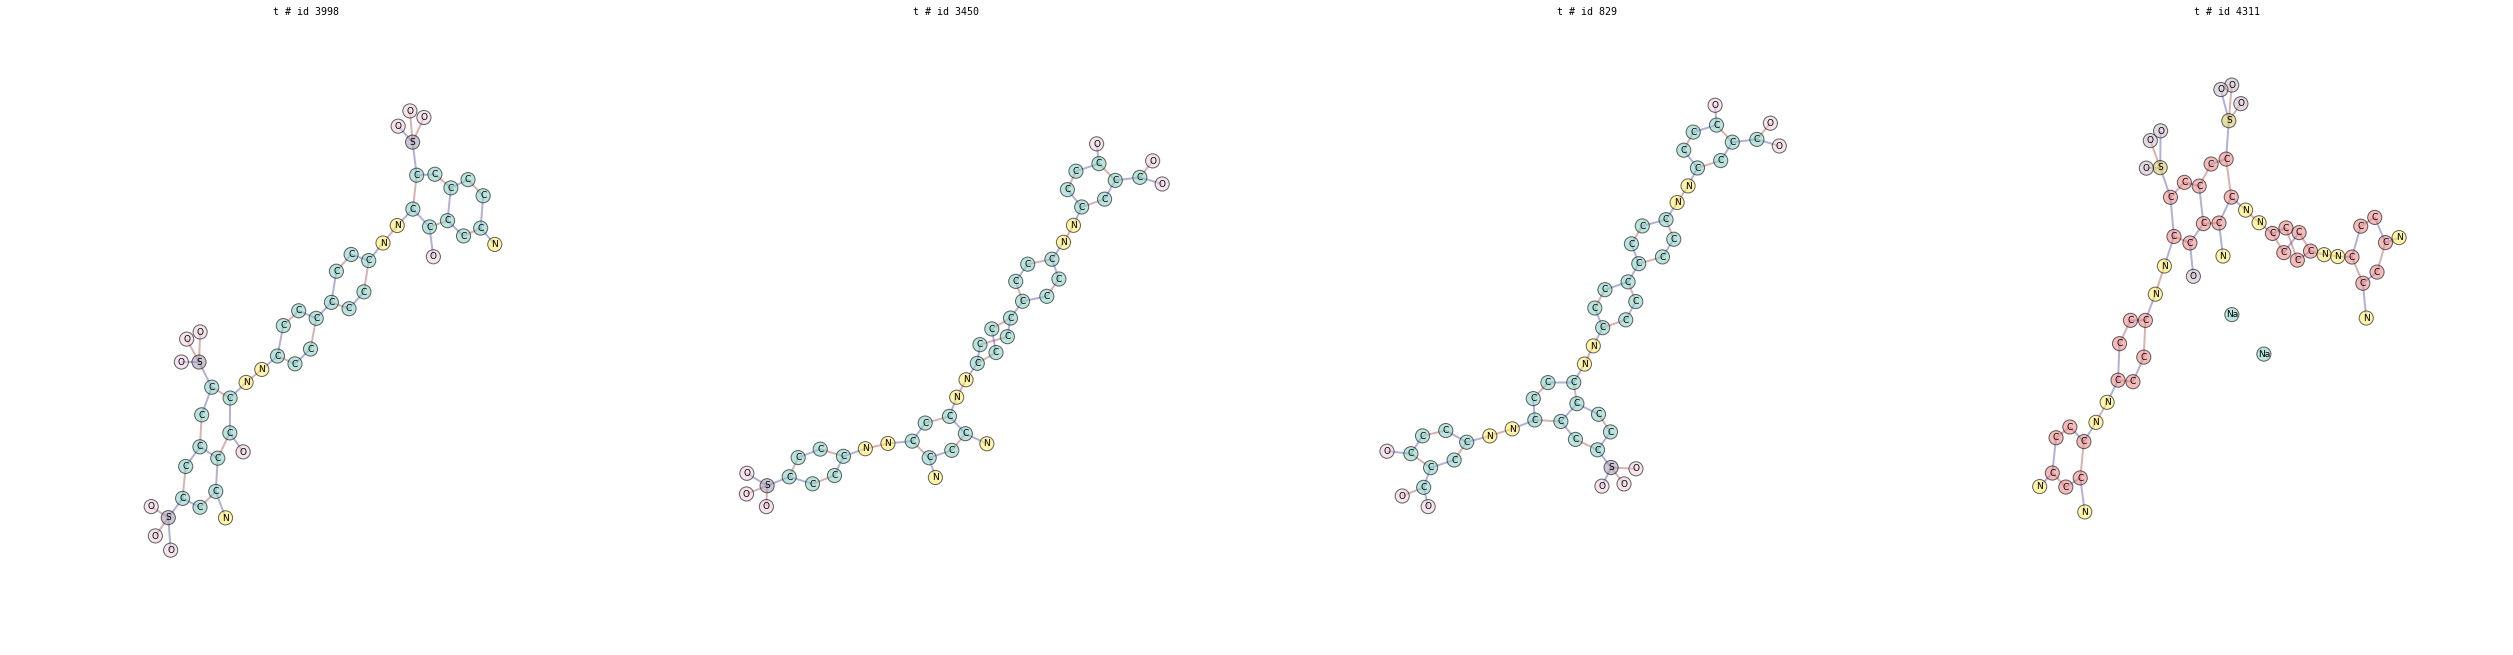

--------------------------------------------------------------------------------
cluster:17 size:6


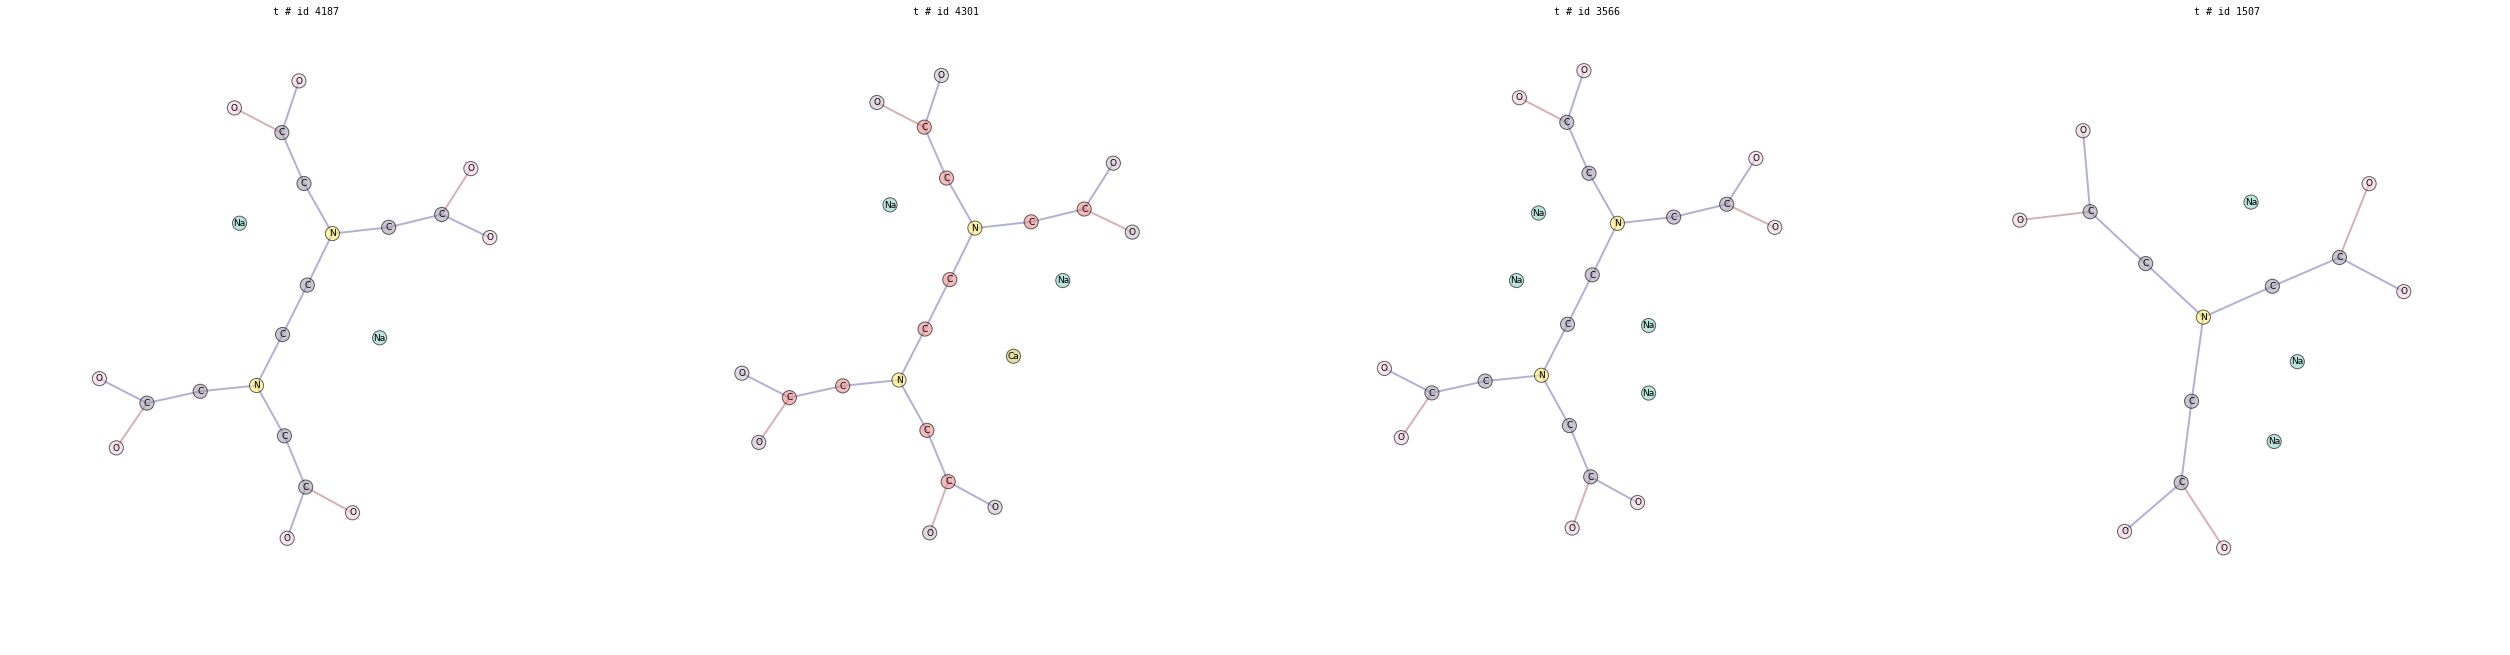

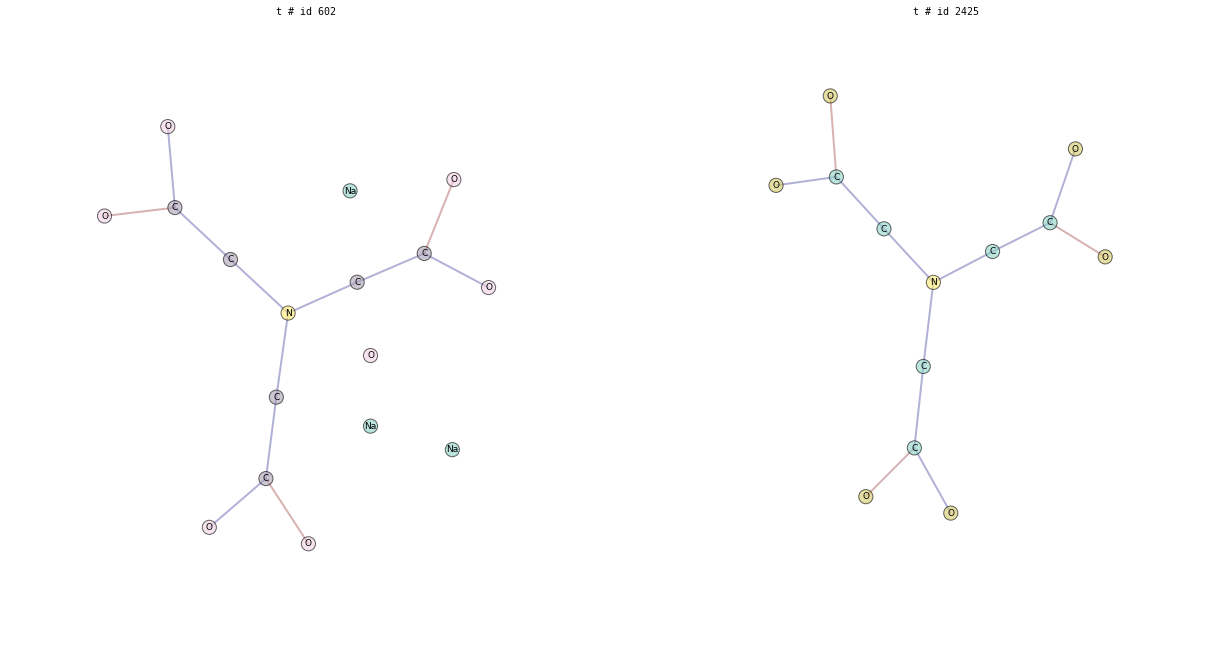

--------------------------------------------------------------------------------
cluster:18 size:6


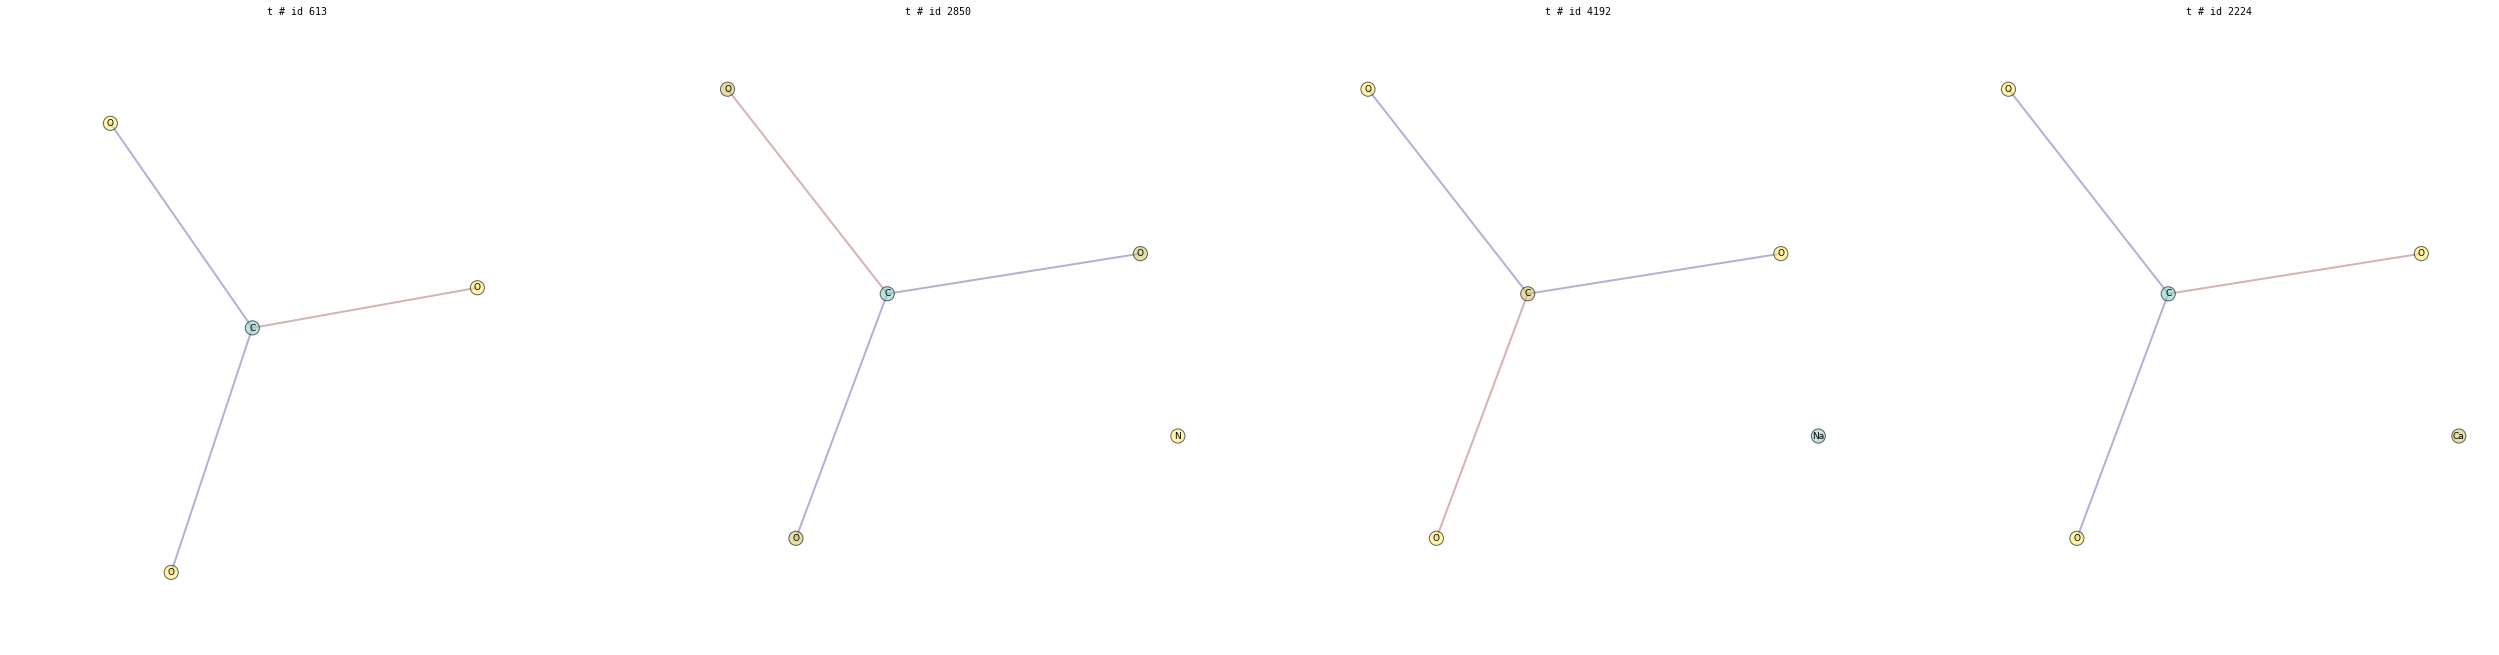

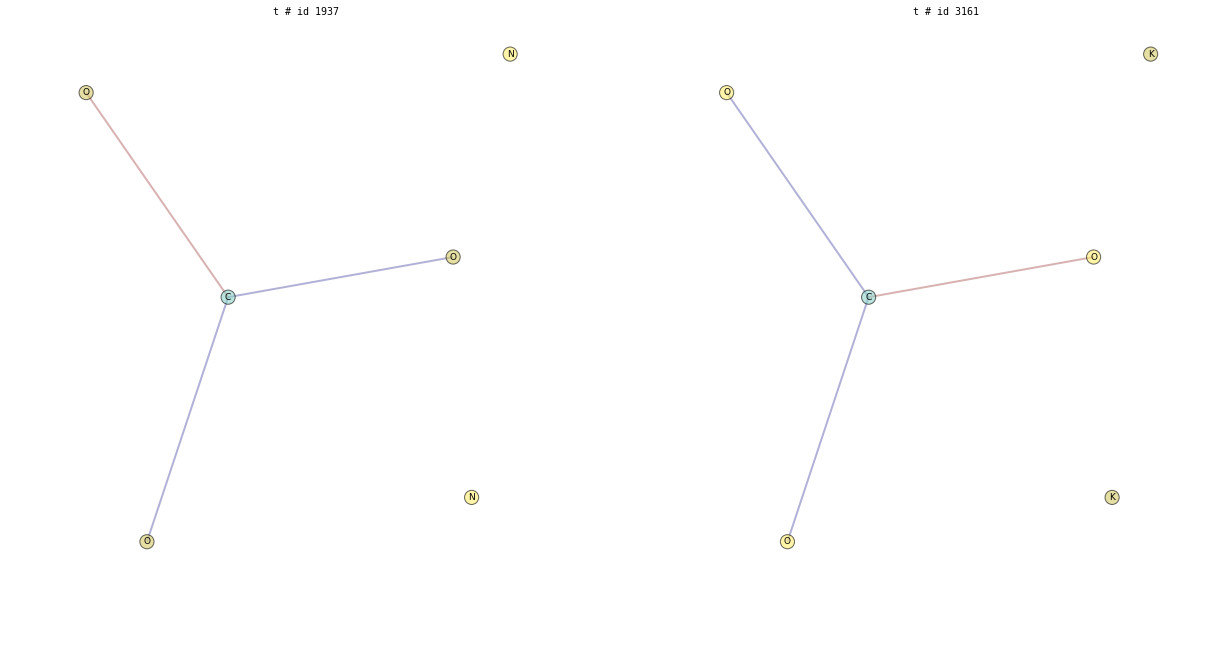

--------------------------------------------------------------------------------
cluster:20 size:7


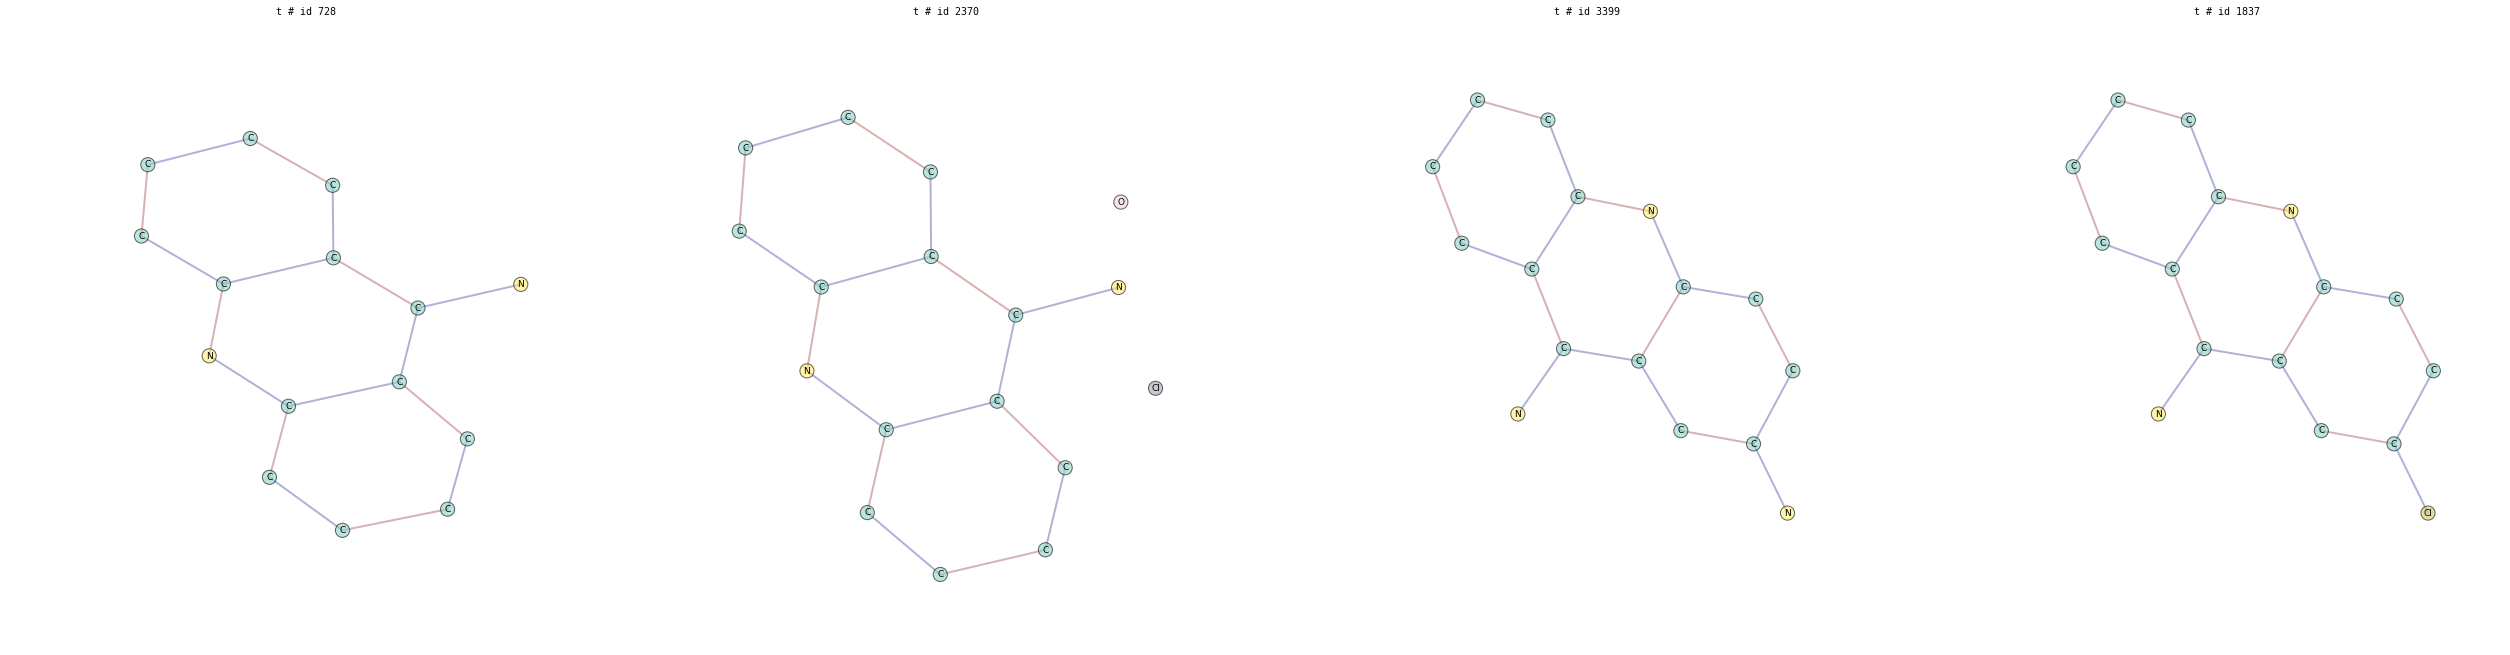

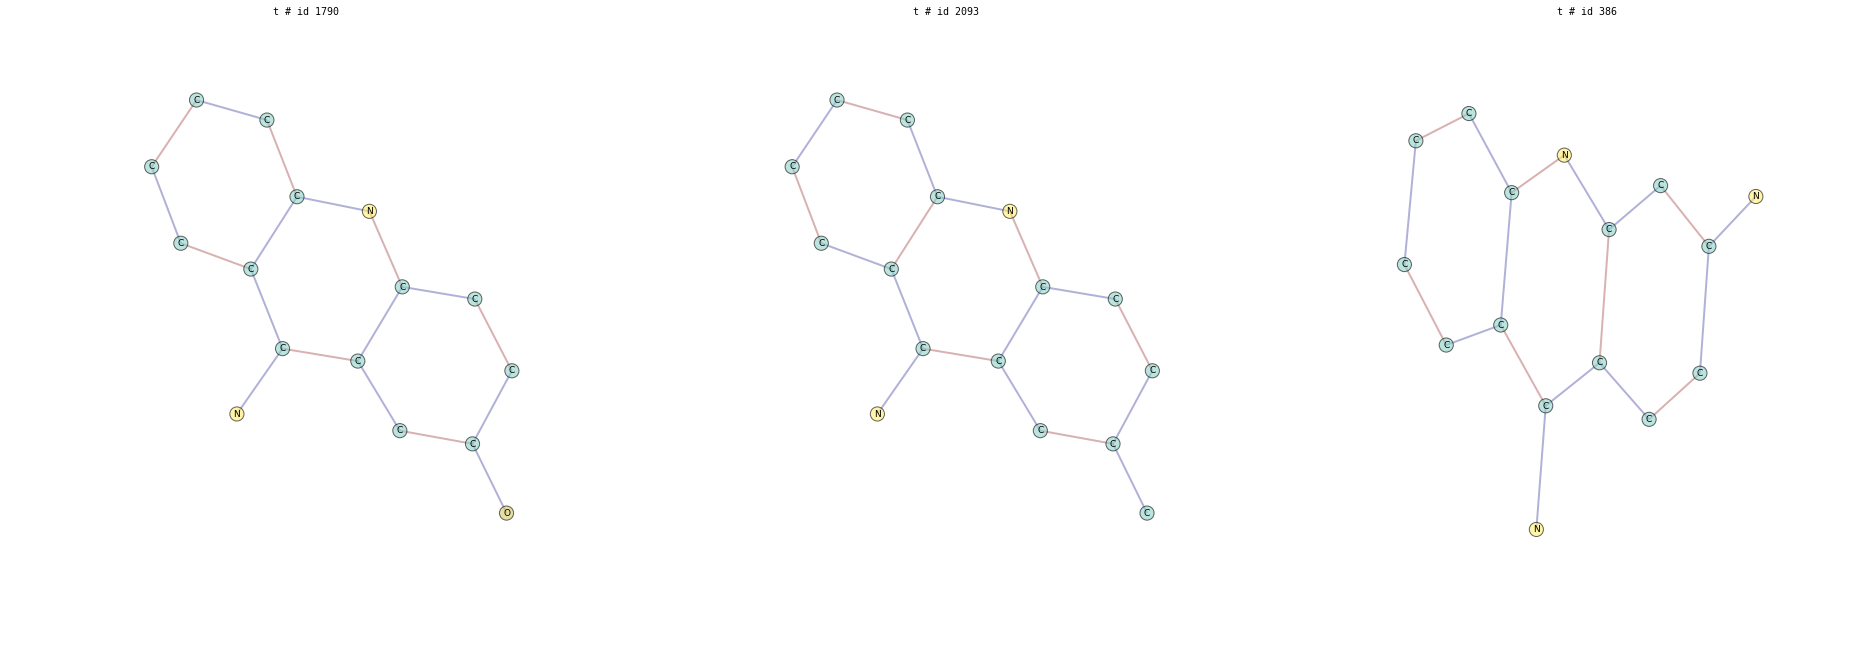

--------------------------------------------------------------------------------
cluster:21 size:6


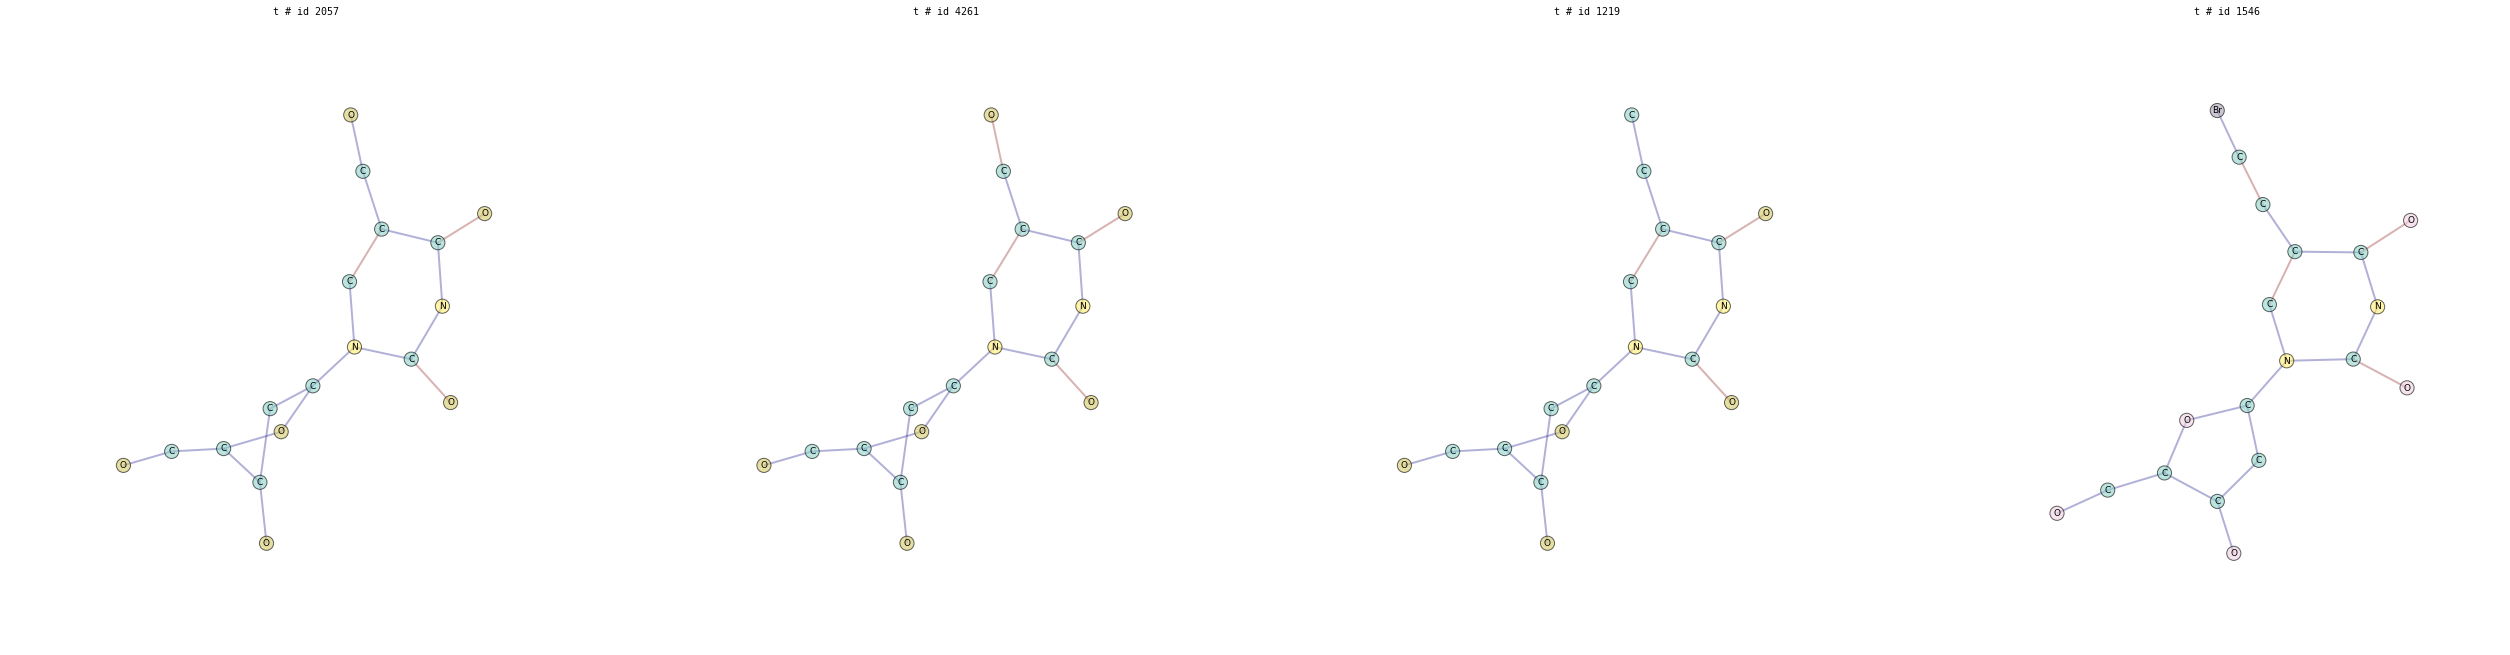

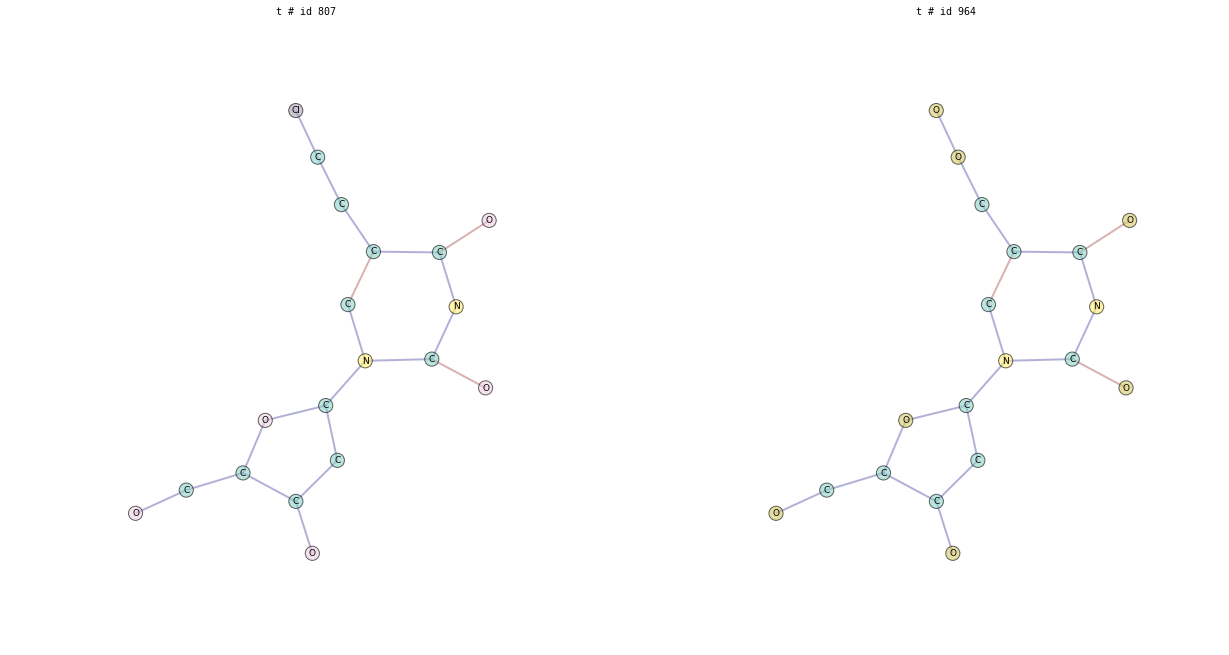

--------------------------------------------------------------------------------
cluster:23 size:6


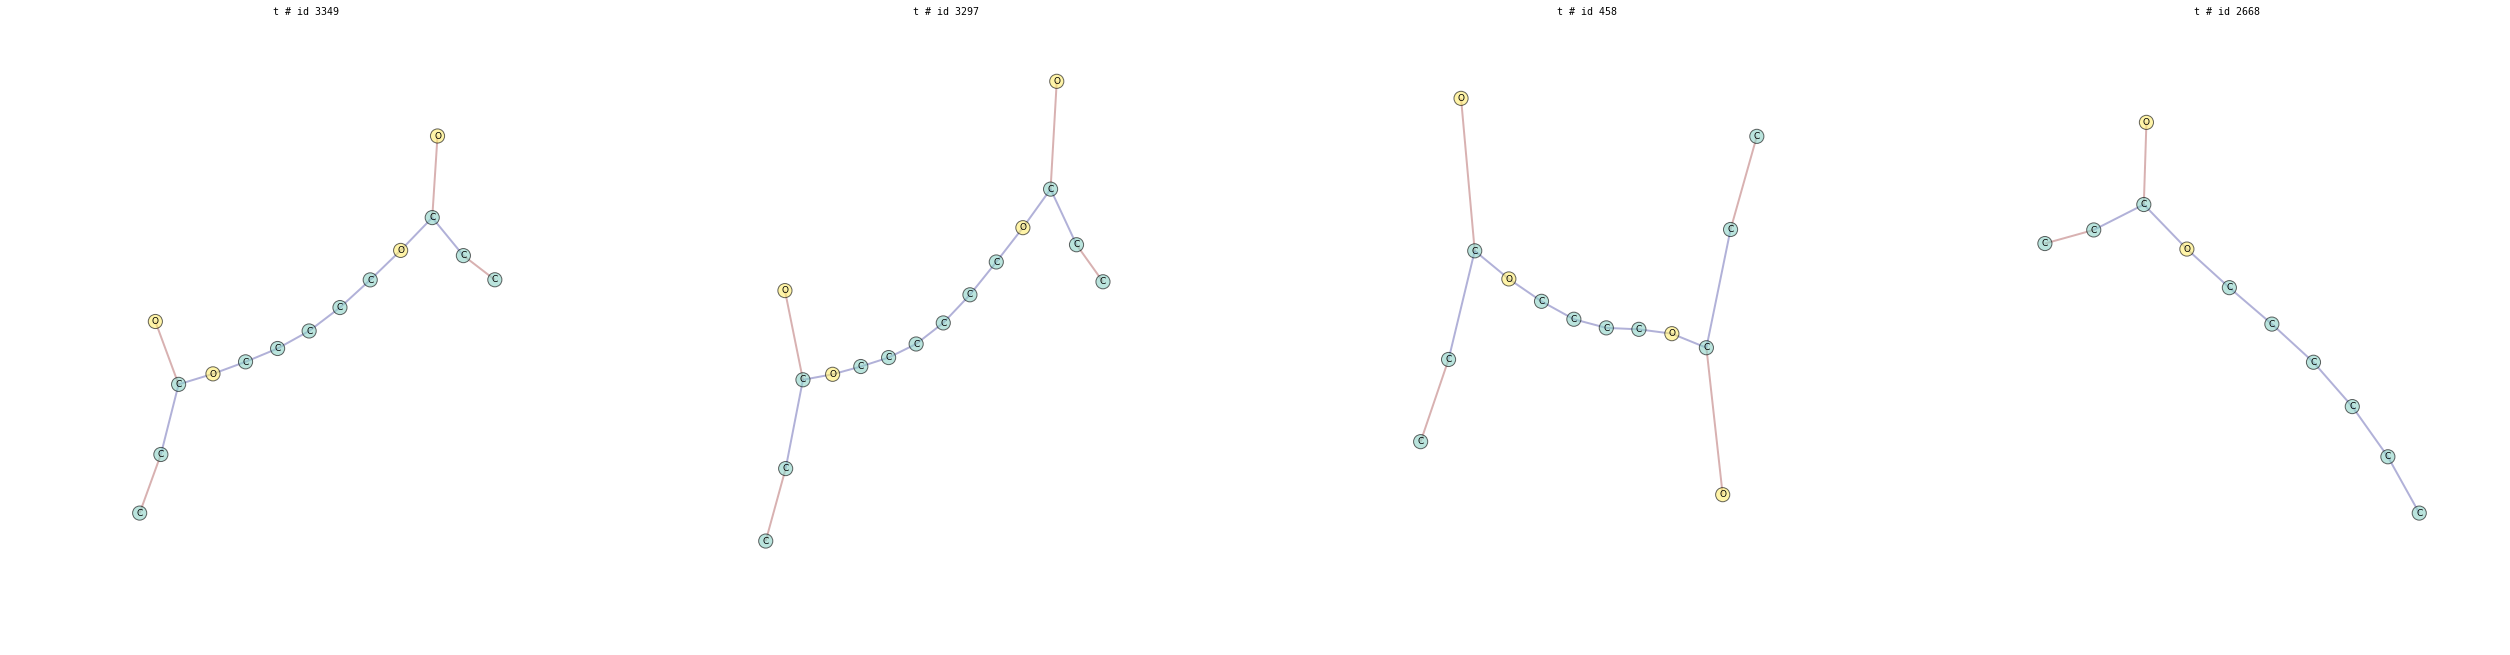

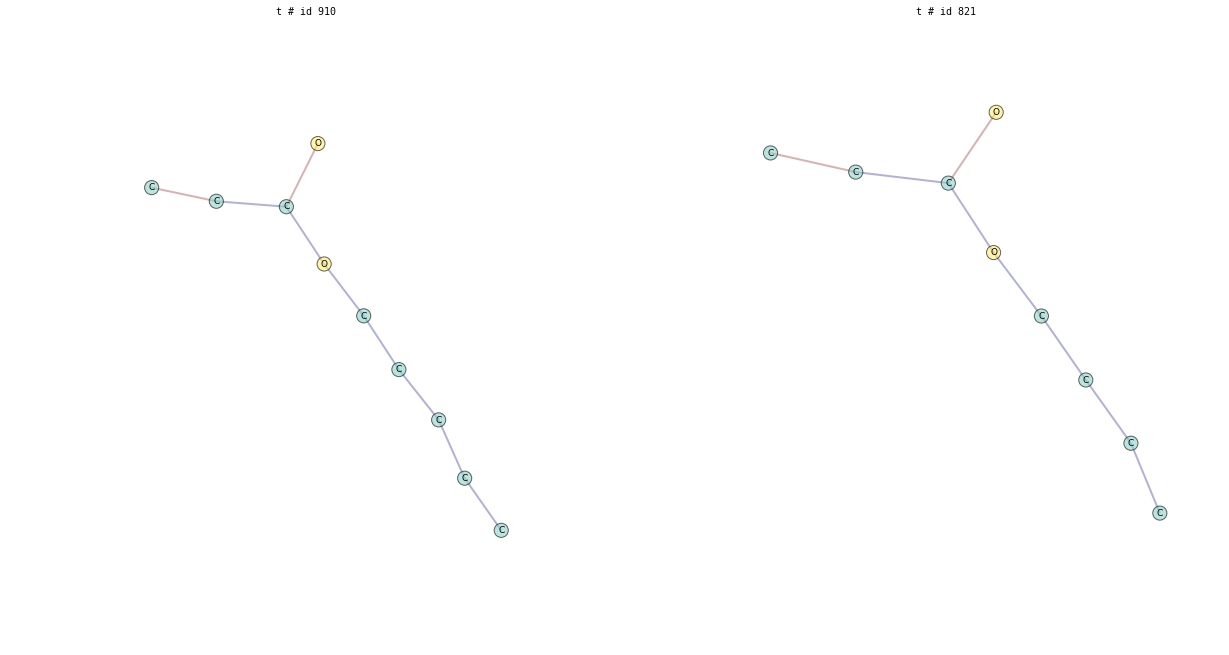

--------------------------------------------------------------------------------
cluster:24 size:6


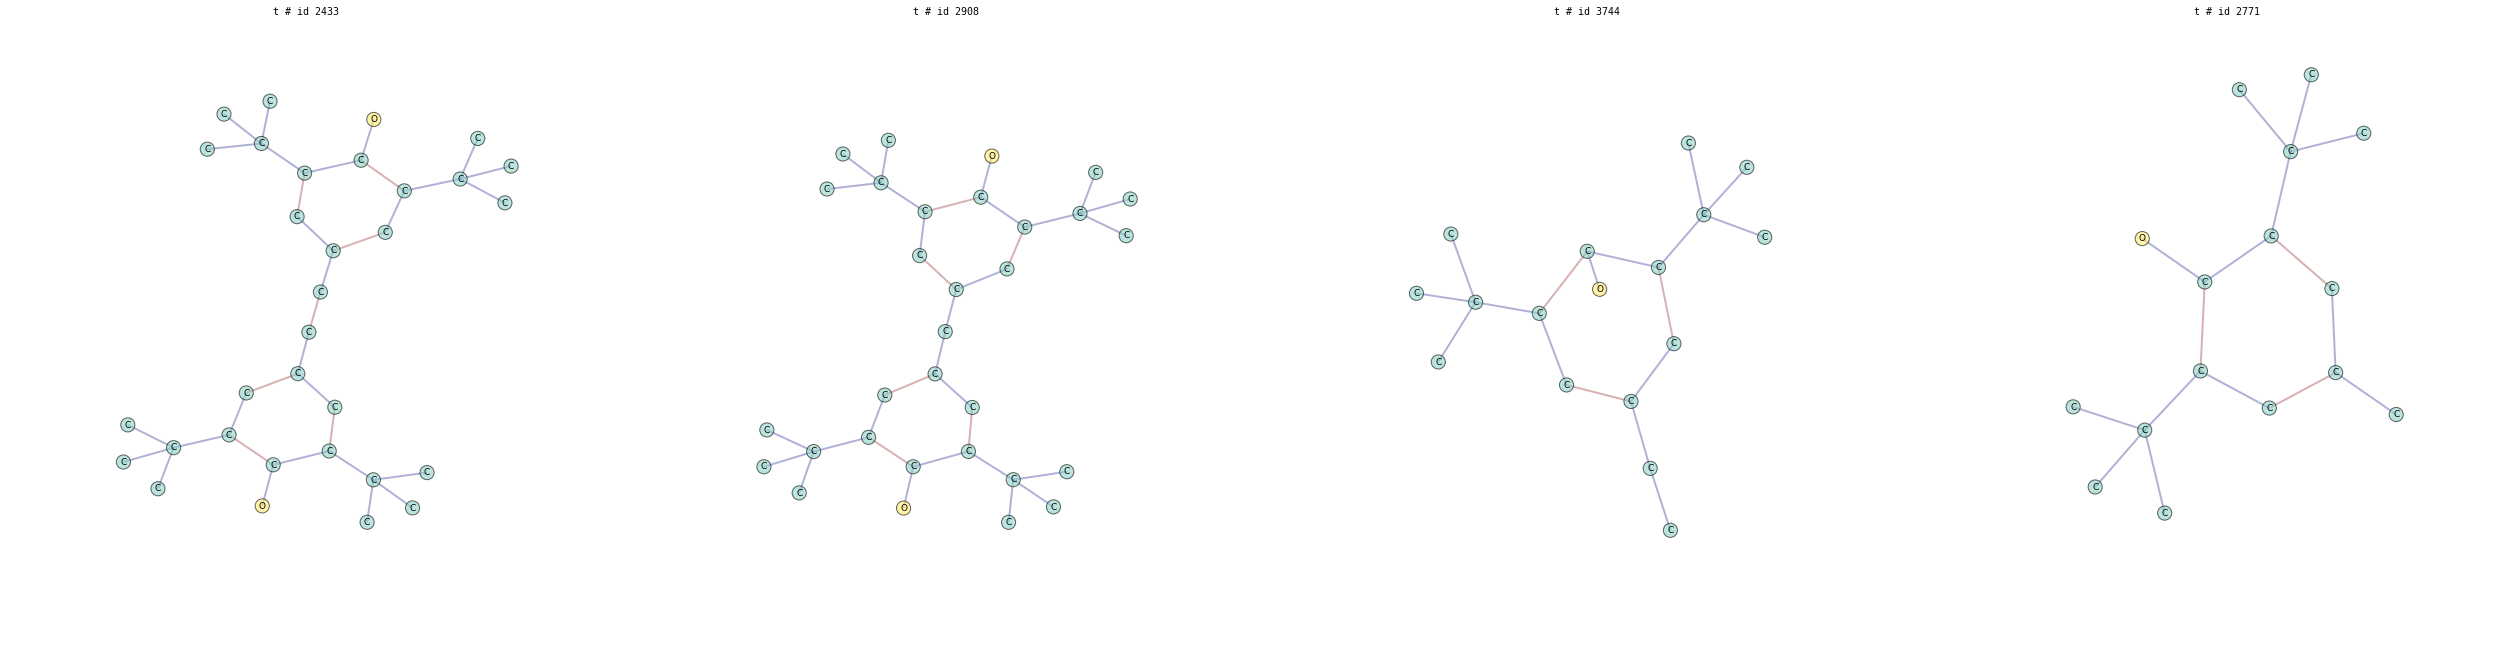

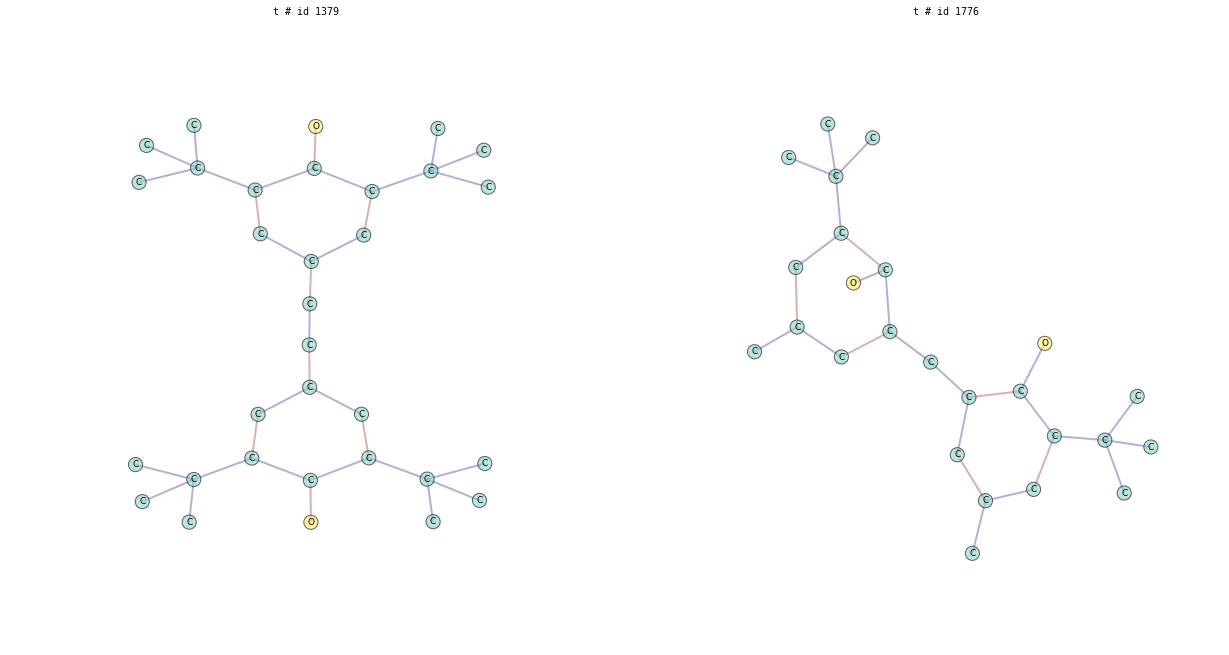

--------------------------------------------------------------------------------
cluster:25 size:7


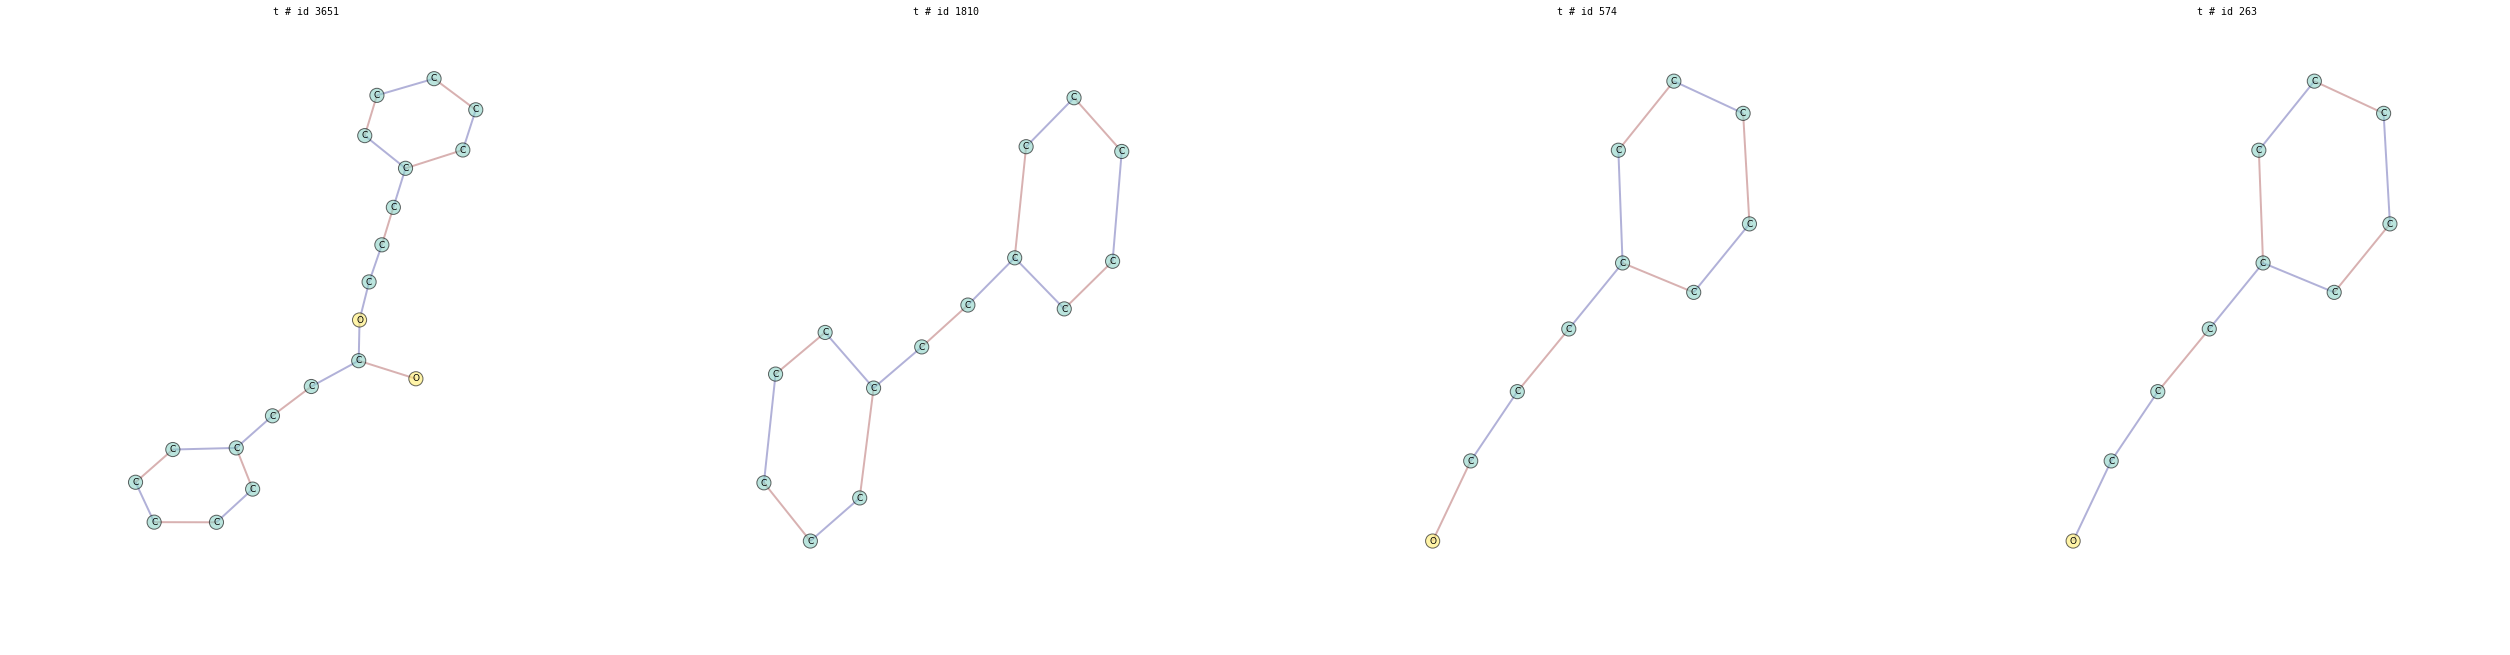

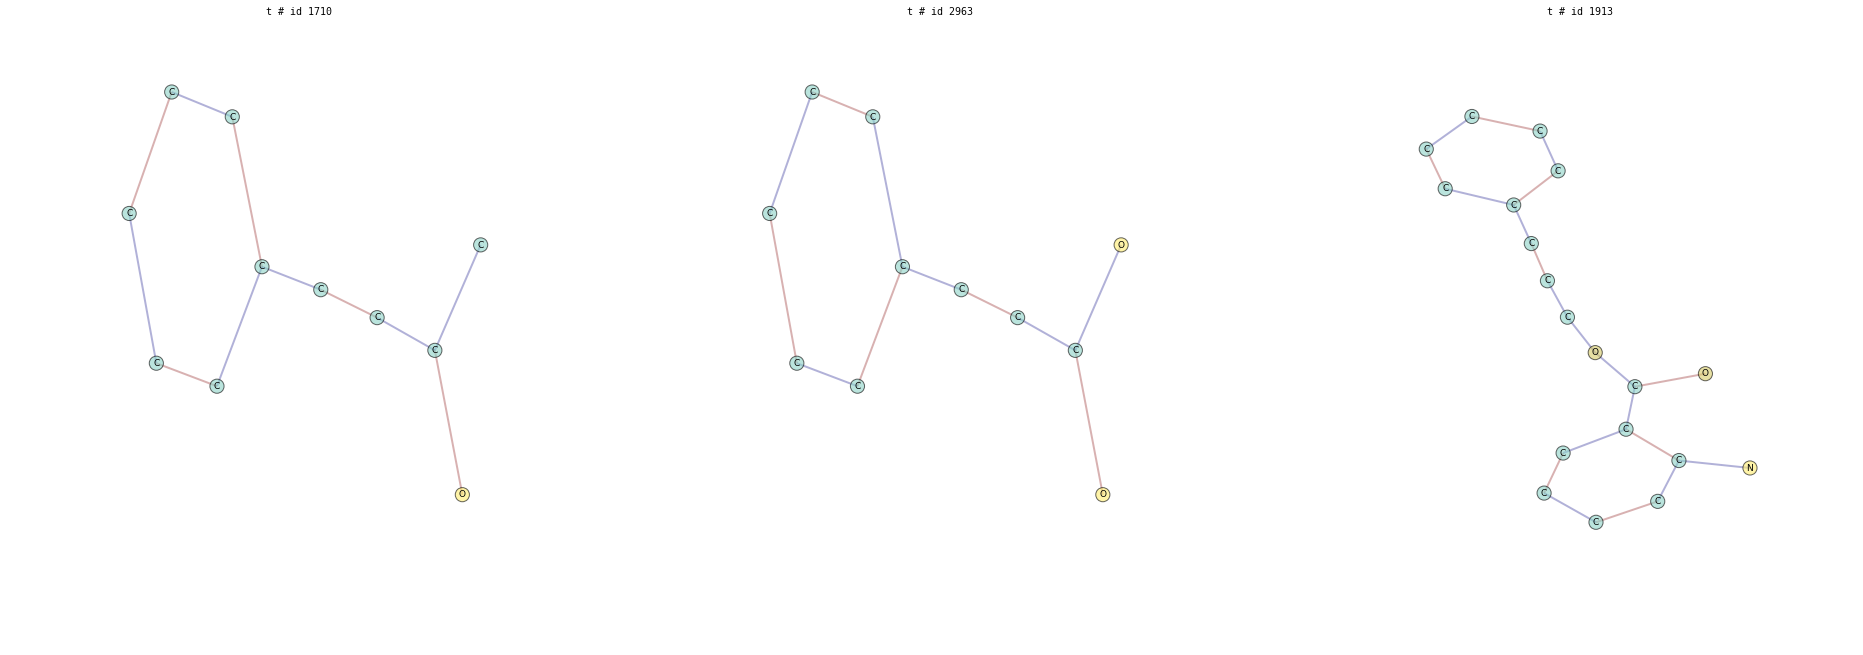

--------------------------------------------------------------------------------
cluster:27 size:6


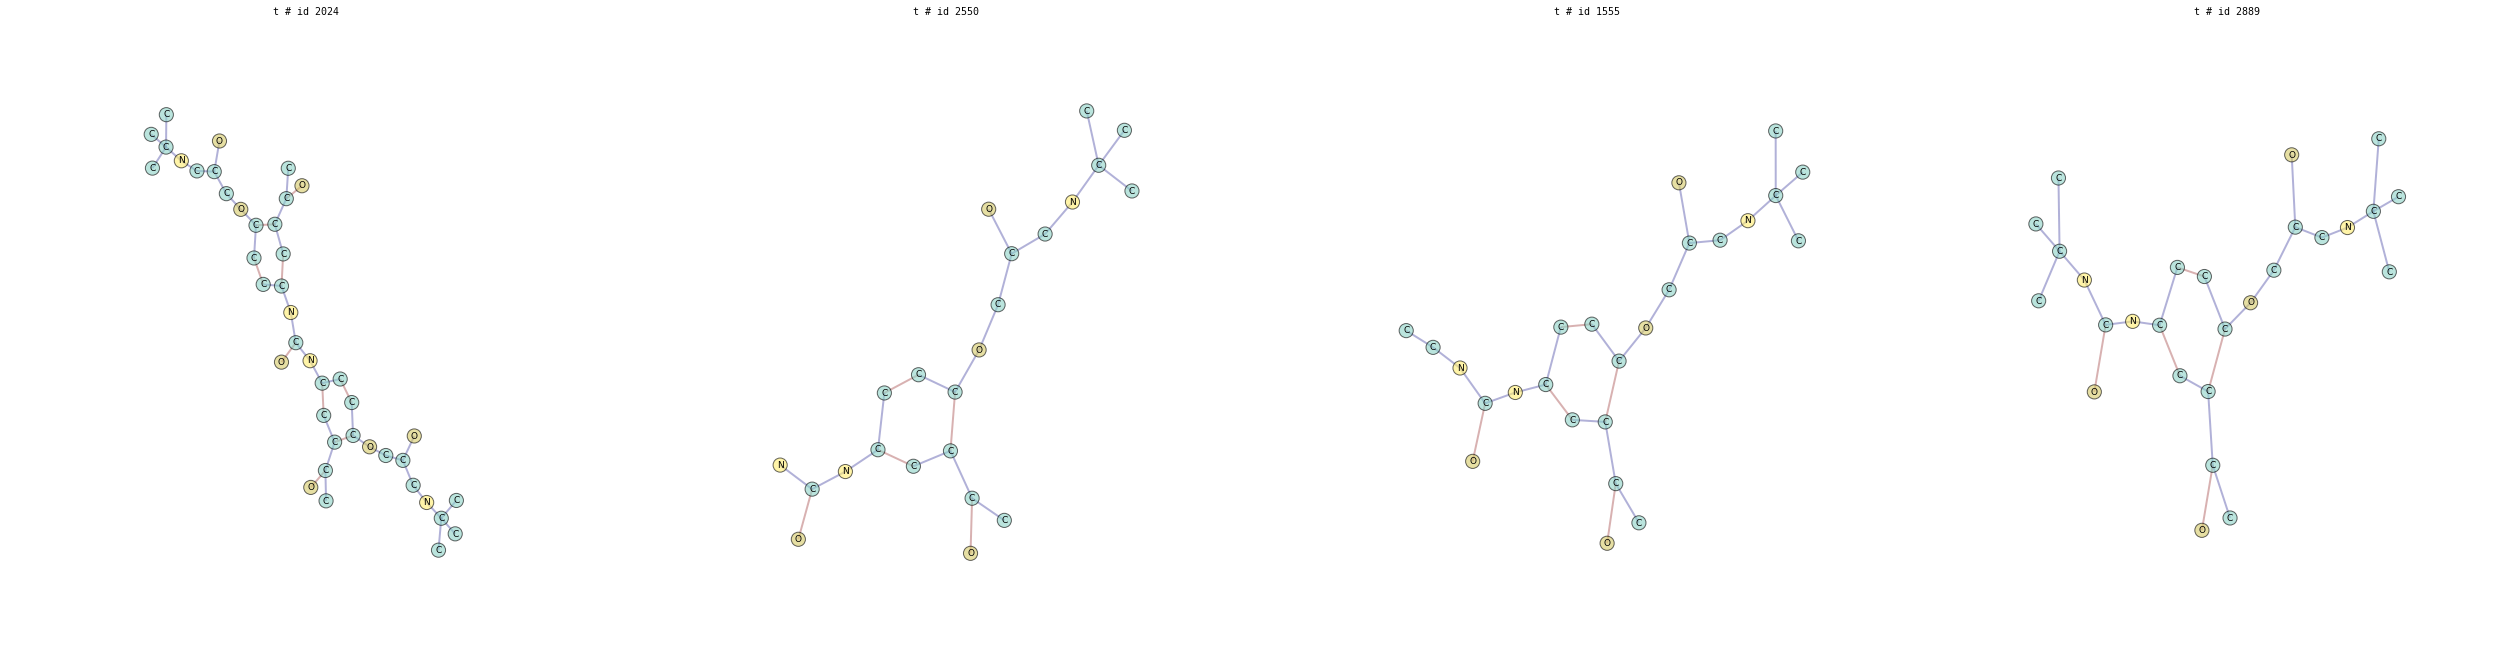

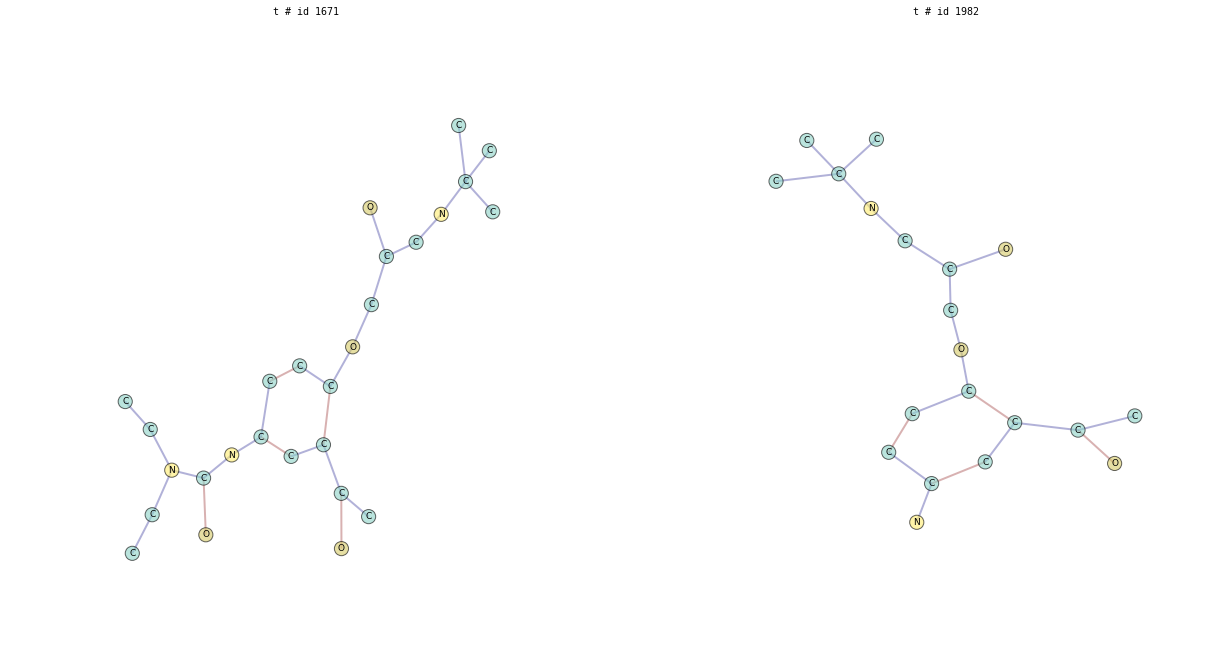

--------------------------------------------------------------------------------
cluster:28 size:6


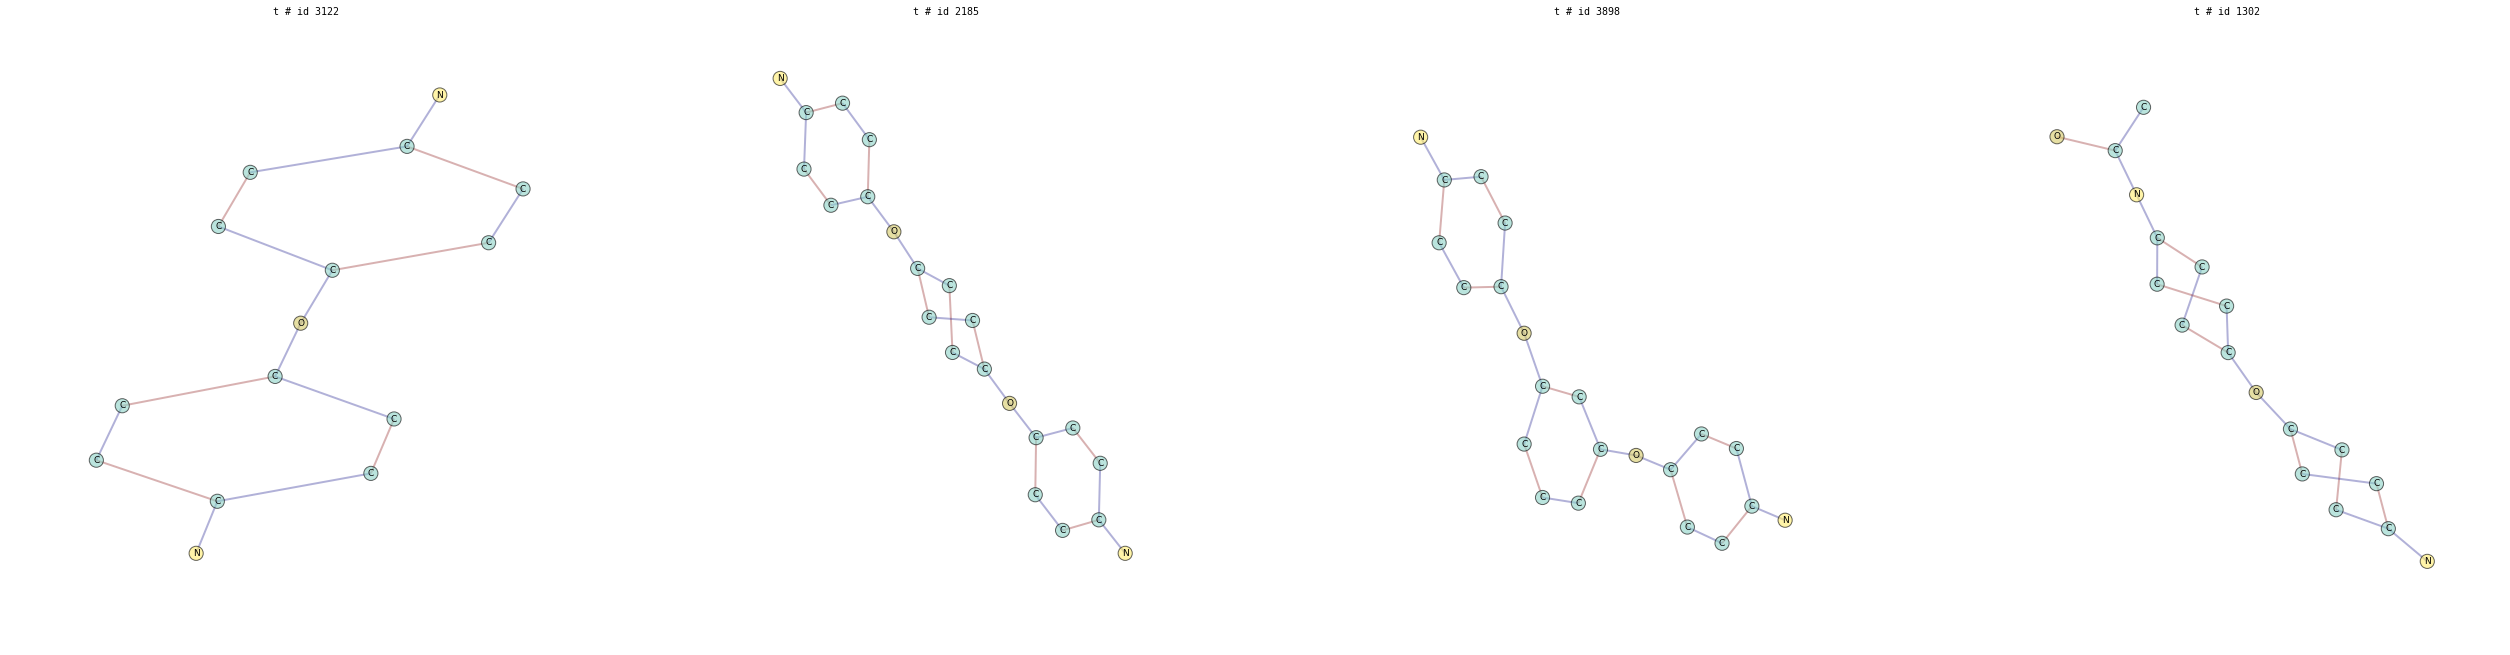

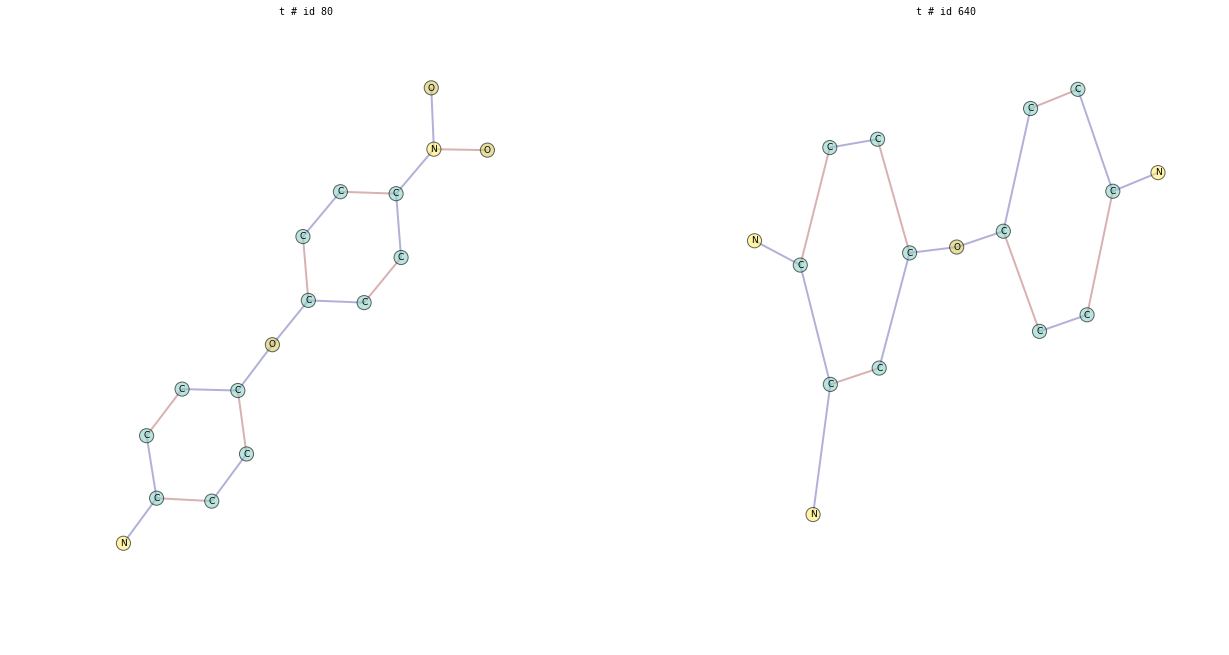

--------------------------------------------------------------------------------
cluster:29 size:6


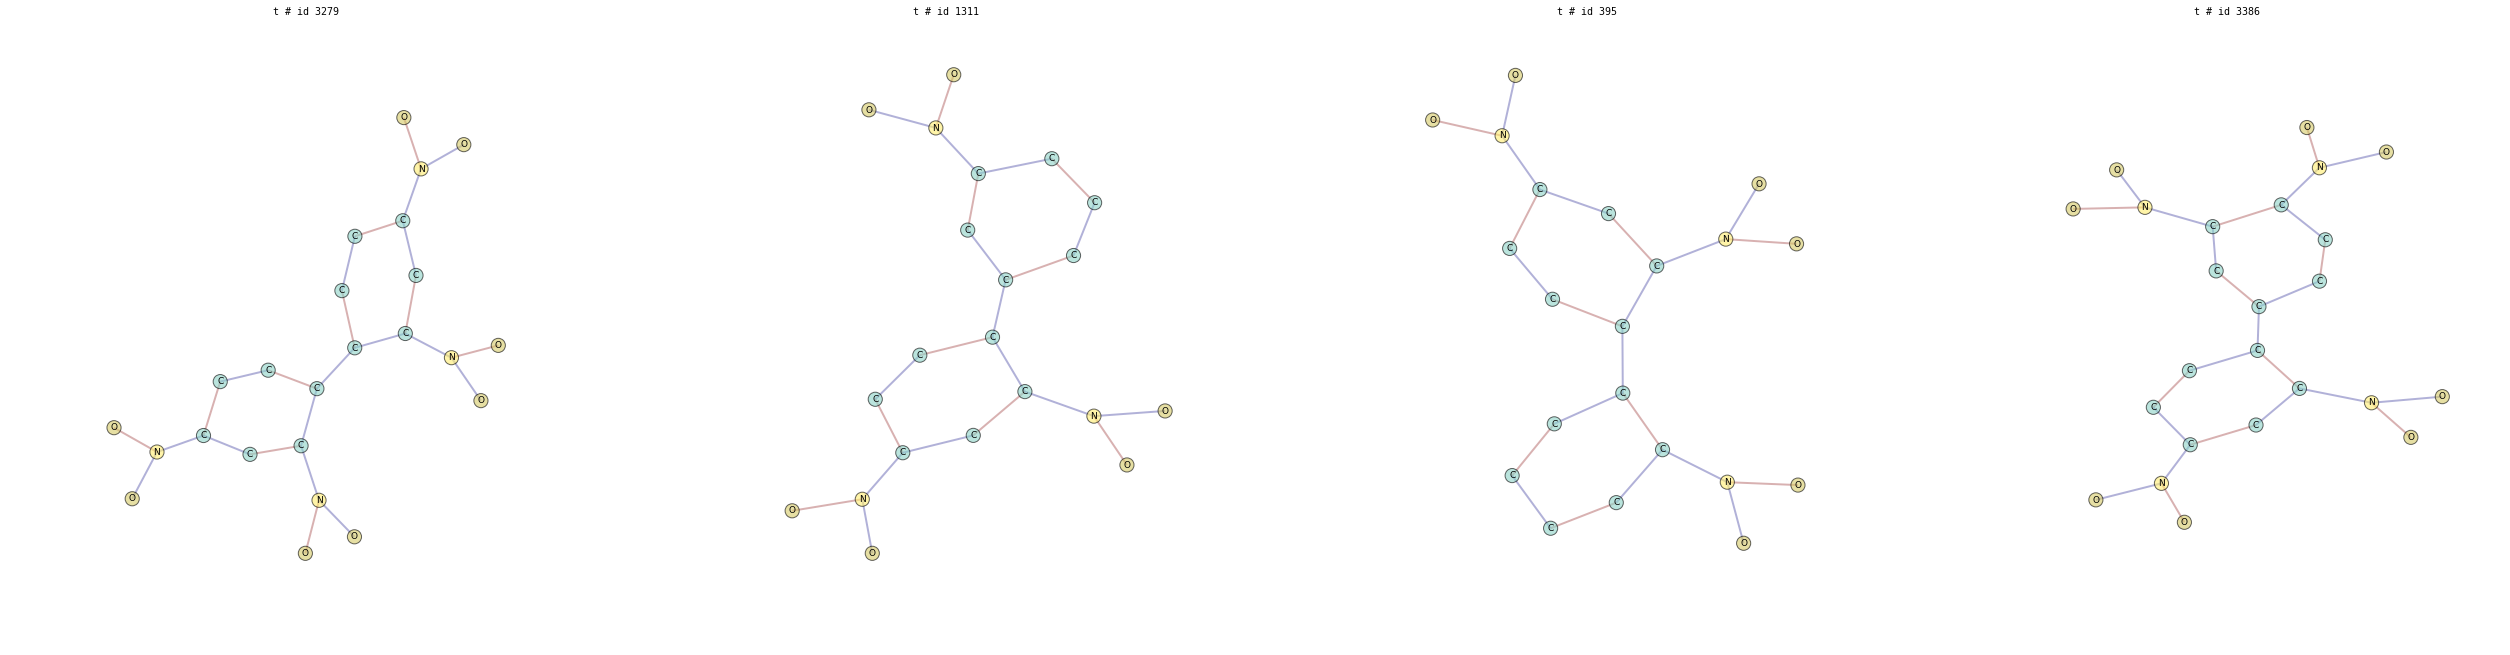

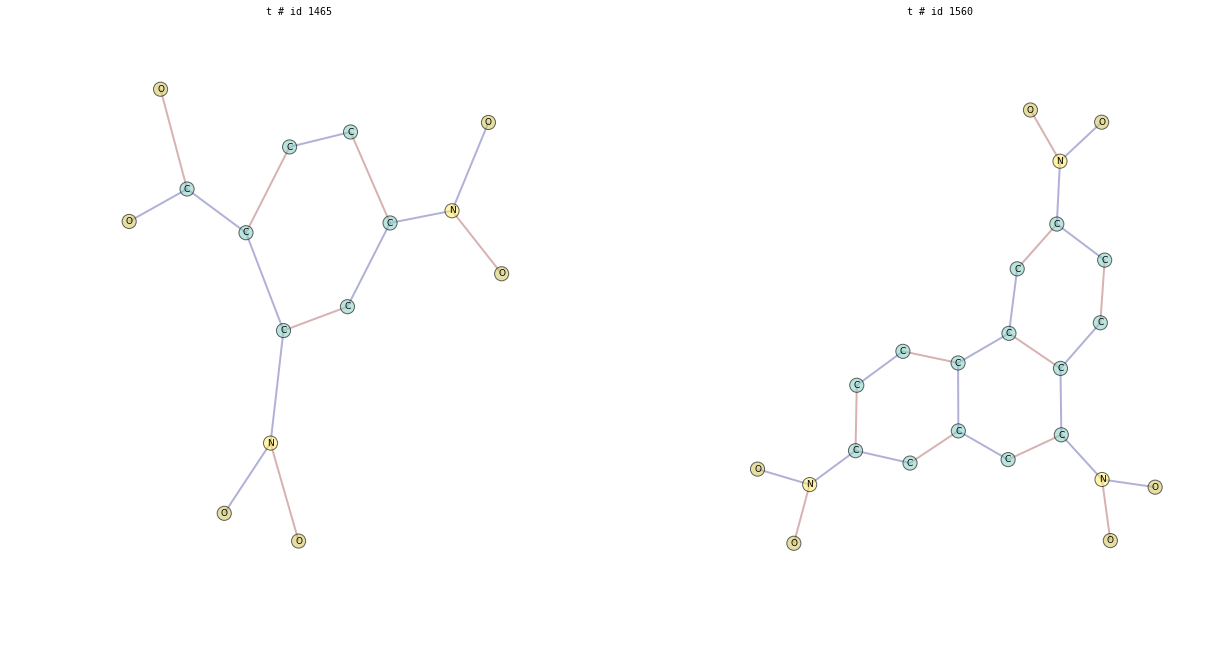

In [23]:
from GArDen.interfaces import order
from GArDen.order.density import DensityEstimator
from GArDen.transform import DeleteEdge
from itertools import islice
from eden.util.display import draw_graph_set

n_graphs_per_line = 3
n_lines = 4
max_n_examples_drawn_per_cluster = n_graphs_per_line * n_lines

for cluster_id in partition_list:
    clust_size = len(partition_list[cluster_id])
    # only show clusters that are not too small or too big
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print '-'*80
        print 'cluster:%d size:%d' % (cluster_id, clust_size)
        # rank graphs by density so to show first the most 'typical' ones
        parameters_priors=dict(reverse=True, metric='rbf', gamma=0.01)
        dense_graphs = order(partition_list[cluster_id], program=DensityEstimator(), parameters_priors=parameters_priors)
        # display only max_n_examples_drawn_per_cluster 
        clustered_graphs = islice(dense_graphs, max_n_examples_drawn_per_cluster) 
        # remove the 'nesting' edges from the graphs so not to display them
        clustered_graphs = transform(clustered_graphs,program=DeleteEdge(), parameters_priors=dict(attribute='nesting',value=True))
        #draw the graphs
        draw_graph_set(clustered_graphs, n_graphs_per_line=4, size=11, title_key='id', prog='neato', node_border=1, node_size=200, colormap='Set3',
                   edge_color='_label_',edge_alpha=.3, vertex_label='label', vertex_color='_label_', ignore_for_layout='nesting')

---

# RNA graphs

In [24]:
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

In [25]:
rfam_id = 'RF00005' #tRNA

In [26]:
from GArDen.interfaces import convert, transform

In [27]:
from GArDen.convert.sequence import FastaToPathGraph
graphs=transform(rfam_uri(rfam_id), program=FastaToPathGraph())

In [28]:
from itertools import islice
igraphs=islice(graphs, 200)

In [38]:
%%time
igraphs = list(igraphs)
graphs=igraphs

CPU times: user 16 µs, sys: 28 µs, total: 44 µs
Wall time: 44.1 µs


In [39]:
from GArDen.transform.rna_structure import PathGraphToRNAShapes
parameters_priors=dict(shape_type=5, energy_range=10, max_num=3, output_type='components')
graphs=transform(graphs, program=PathGraphToRNAShapes(), parameters_priors=parameters_priors)

In [40]:
from GArDen.transform.rna_annotation import AnnotateSecondaryStructureElements
graphs=transform(graphs, program=AnnotateSecondaryStructureElements())

In [41]:
from GArDen.transform.contraction import Minor, contraction_modifier
#reduce all 'part_name' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
label_modifier = contraction_modifier(attribute_in='part_name', attribute_out='label', reduction='set_categorical')
#reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
modifiers = [label_modifier, weight_modifier]

from GArDen.interfaces import transform
priors=dict(nesting=True,  modifiers=[modifiers], weight_scaling_factor=1000)
graphs=transform(graphs, program=Minor(), parameters_priors=priors)

In [42]:
from GArDen.transform.node import MultiplicativeReweightDictionary
weight_dict = {'label':{'s':1, 'm':5, 'h':1, 'i':5}}
graphs=transform(graphs, program=MultiplicativeReweightDictionary(),parameters_priors=dict(weight_dict=[weight_dict]))

In [43]:
from sklearn.cluster import KMeans
parameters_priors=dict(n_clusters=50, init='k-means++', n_init=10, max_iter=50, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=-1)
clusterer = KMeans()

In [44]:
from GArDen.partition import ClustererWrapper
wrapped_clusterer = ClustererWrapper(program=clusterer)

In [45]:
%%time
from GArDen.interfaces import partition
parameters_priors.update(dict(vectorizer__r=2,vectorizer__d=2, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
partition_list = partition(graphs, program=wrapped_clusterer, parameters_priors=parameters_priors)

CPU times: user 17 s, sys: 14.2 s, total: 31.2 s
Wall time: 1min 32s


In [46]:
# print info on graphs that are not too small or too big
min_clust_size = 8
max_clust_size = 15
for cluster_id in partition_list:
    clust_size=len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print 'cluster id: %d size:%d' % (cluster_id, clust_size )

cluster id: 1 size:13
cluster id: 6 size:11
cluster id: 9 size:9
cluster id: 14 size:12
cluster id: 17 size:11
cluster id: 20 size:11
cluster id: 22 size:14
cluster id: 25 size:9
cluster id: 32 size:10
cluster id: 33 size:10
cluster id: 38 size:10
cluster id: 40 size:9
cluster id: 42 size:10


In [ ]:
from GArDen.interfaces import order
from GArDen.order.density import DensityEstimator
from GArDen.transform import DeleteEdge
from itertools import islice
from eden.util.display import draw_graph_set

n_graphs_per_line = 3
n_lines = 4
max_n_examples_drawn_per_cluster = n_graphs_per_line * n_lines

for cluster_id in partition_list:
    clust_size = len(partition_list[cluster_id])
    # only show clusters that are not too small or too big
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print '-'*80
        print 'cluster:%d size:%d' % (cluster_id, clust_size)
        # rank graphs by density so to show first the most 'typical' ones
        parameters_priors=dict(reverse=True, metric='rbf', gamma=0.01)
        dense_graphs = order(partition_list[cluster_id], program=DensityEstimator(), parameters_priors=parameters_priors)
        # display only max_n_examples_drawn_per_cluster 
        clustered_graphs = islice(dense_graphs, max_n_examples_drawn_per_cluster) 
        # remove the 'nesting' edges from the graphs so not to display them
        clustered_graphs = transform(clustered_graphs,program=DeleteEdge(), parameters_priors=dict(attribute='nesting',value=True))
        #draw the graphs
        draw_graph_set(clustered_graphs, n_graphs_per_line=3, size=14, title_key='header', prog='neato', 
                       node_border=1, node_size=200, colormap='autumn',
                       edge_color='_label_',edge_alpha=.3, vertex_label='label', 
                       vertex_color='weight', ignore_for_layout='nesting')

---